# Clustering of Burst Events from cultured neurons

## Import Packages

In [0]:
!pip install git+https://github.com/musically-ut/l1-ls.py.git@master#egg=l1ls

  Cloning https://github.com/musically-ut/l1-ls.py.git (to revision master) to /tmp/pip-install-1jap08jz/l1ls
  Running command git clone -q https://github.com/musically-ut/l1-ls.py.git /tmp/pip-install-1jap08jz/l1ls
  Created wheel for l1ls: filename=l1ls-0.2.1-cp36-none-any.whl size=12282 sha256=fa2666fc292a2cdcc19c67ec74be67314f1efc2efd12b9f300443ff26d55cfc7
  Stored in directory: /tmp/pip-ephem-wheel-cache-37lye3xc/wheels/fb/ca/81/8741706c0887e20839b67a5eb4e62e1c4f4d25bd8f210f0222
Successfully built l1ls


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import scipy
from scipy.io import loadmat
from scipy.io import savemat
import matplotlib.pyplot as plt 
import pandas as pd
import struct
import os
import json
import sys
import seaborn as sns 
from scipy import signal, stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [0]:
import l1ls as L

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!ls "/content/gdrive/My Drive/"

 Burst_data  'Colab Notebooks'


## Helper Functions


In [0]:
SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 50

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)

## Dataset
- whole dataset
- dataset without bursts referred to as tiny
- dataset containing only bursts referred to as tiny

In [0]:
#padded_data = np.load('/content/gdrive/My Drive/Burst_data/padded_data.npy')
#padded_data_no_tiny = np.load('/content/gdrive/My Drive/Burst_data/padded_data_no_tiny.npy')
#padded_data_tiny = np.load('/content/gdrive/My Drive/Burst_data/padded_data_tiny.npy')

In [0]:
data_burst_by_time = np.load('/content/gdrive/My Drive/Burst_data/data_burst_by_time.npy').T
data_burst_by_time_shuffled = np.random.permutation(data_burst_by_time)
print("Averaged over channels: ", data_burst_by_time.shape)

Averaged over channels:  (13092, 3410)


In [0]:
data_burst_by_time_no_tiny = np.load('/content/gdrive/My Drive/Burst_data/data_burst_by_time_no_tiny.npy').T
data_burst_by_time_shuffled_no_tiny = np.random.permutation(data_burst_by_time_no_tiny)
print("Averaged over channels: ", data_burst_by_time_no_tiny.shape)

FileNotFoundError: ignored

In [0]:
data_burst_by_time_tiny = np.load('/content/gdrive/My Drive/Burst_data/data_burst_by_time_tiny.npy').T
data_burst_by_time_shuffled_tiny = np.random.permutation(data_burst_by_time_tiny)
print("Averaged over channels: ", data_burst_by_time_tiny.shape)

# Tiny Bursts

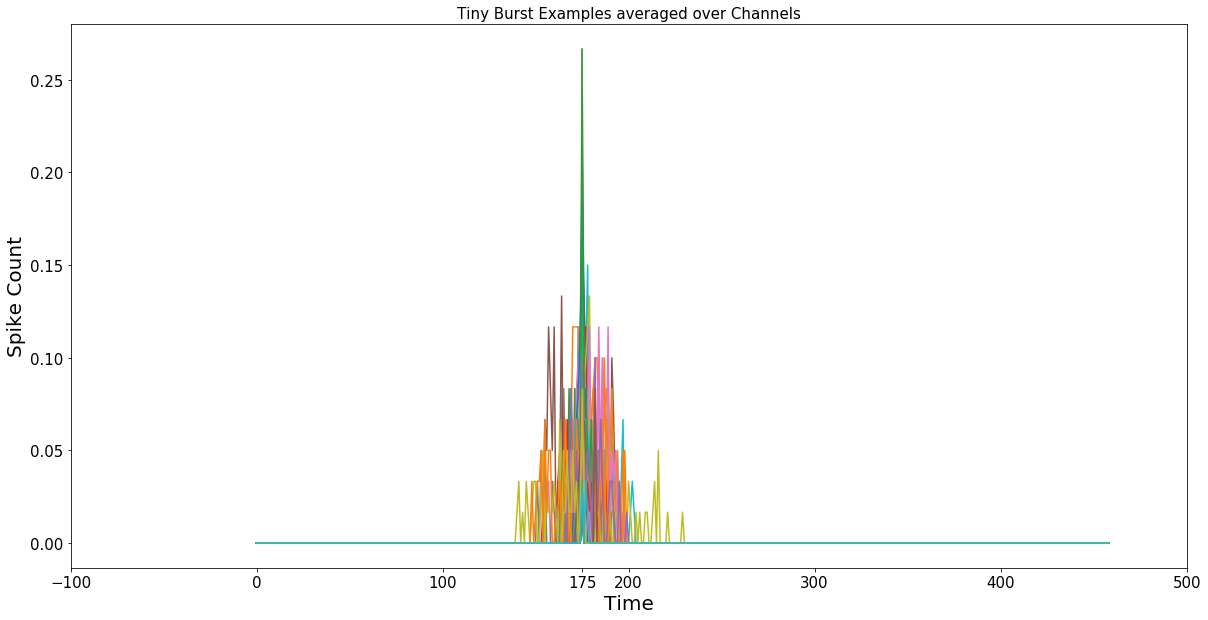

In [0]:
plt.figure(figsize=(20,10))
for burst in data_burst_by_time_shuffled_tiny.T[0:100]:
    plt.plot(burst)
plt.xlabel("Time")
plt.ylabel("Spike Count")
plt.title("Tiny Burst Examples averaged over Channels")    
plt.xticks(list(plt.xticks()[0]) + [data_center_tiny])
plt.show()

In [0]:
representative = np.mean(data_burst_by_time_shuffled_tiny.T, axis = 0)
quantile1 = np.quantile(data_burst_by_time_shuffled_tiny.T, 0.25, axis=0)
quantile3 = np.quantile(data_burst_by_time_shuffled_tiny.T, 0.75, axis=0)
median = np.median(data_burst_by_time_shuffled_tiny.T, axis = 0)

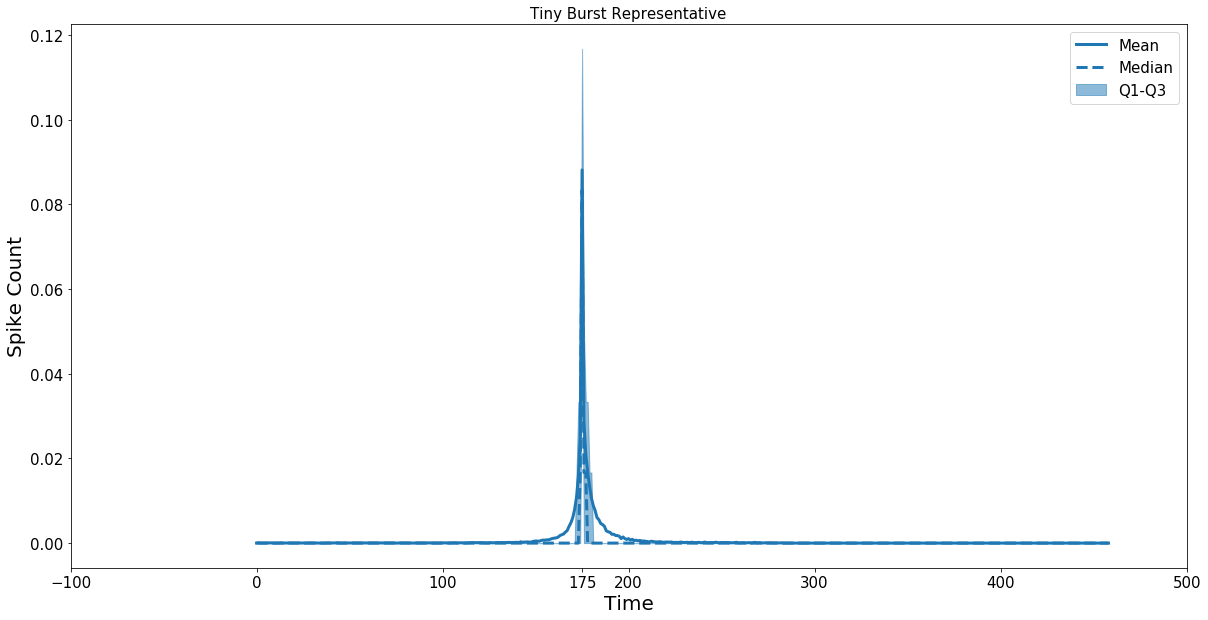

In [0]:
plt.figure(figsize=(20,10))
ax = plt.axes()
ax.plot(representative, color = "C0", lw = 3, label = "Mean")
ax.plot(median, color = "C0", lw = 3, ls = '--', label = "Median")
ax.fill_between(range(len(quantile1)), quantile1,quantile3 ,color = "C0",alpha=0.5, label = "Q1-Q3")
plt.title("Tiny Burst Representative")    
plt.xlabel("Time")
plt.ylabel("Spike Count")  
plt.xticks(list(plt.xticks()[0]) + [data_center_tiny])
plt.legend()
plt.show()

# Burst Clustering

In [0]:
from matplotlib import cm
import warnings


def plot_cluster_representatives(burst_data, labels, n_clusters,figsize=(30,15)):
    representatives = []
    for i in range(n_clusters):
        class_i = burst_data[np.where(labels == i)]
        representative = np.mean(class_i, axis = 0)
        quantile1 = np.quantile(class_i, 0.25, axis=0)
        quantile3 = np.quantile(class_i, 0.75, axis=0)
        median = np.median(class_i, axis = 0)
    
        representatives.append([representative,quantile1,quantile3,median])

    fig = plt.figure(figsize=figsize)
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    
    if n_clusters < 10:
        colors = ["C" + str(i) for i in range(n_clusters)]
    else:
        colors = cm.rainbow(np.linspace(0, 1, n_clusters))
    rows = int(np.ceil(n_clusters/3)) 
    for i in range(n_clusters):
        if i < n_clusters:
            count = i + 1
        ax = fig.add_subplot(rows, 3, count)
        ax.set_ylim([0,max(representatives[i][2]) * 1.1])
        
        for j,representative in enumerate(representatives):
            if i == j:
                ax.plot(representative[0], color = colors[i], lw = 3, label = "Mean")
                ax.plot(representative[3], color = colors[i], lw = 3, ls = '--', label = "Median")
                ax.fill_between(range(len(representative[1])), representative[1],representative[2],color = colors[i],alpha=0.5, label = "Q1-Q3")
                #ax.plot(representative[1], color = colors[i], lw = 1, ls = '--')
                #ax.plot(representative[2], color = colors[i], lw = 1, ls = '--')
                ax.legend()
            else:
                ax.plot(representative[0], color = colors[j], alpha=0.3)
                #ax.plot(representative[1], color = colors[j], alpha=0.3)
                #ax.plot(representative[2], color = colors[j], alpha=0.3)
            
            ax.set_xlabel("Time")
            ax.set_title("Class %i " % i)
            

def plot_normalized_cluster_examples(burst_data, labels, n_clusters):
    fig = plt.figure(figsize=(30,15))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    rows = int(np.ceil(n_clusters/3)) 
    if n_clusters < 10:
        colors = ["C" + str(i) for i in range(n_clusters)]
    else:
        colors = cm.rainbow(np.linspace(0, 1, n_clusters))
        
    for i in range(n_clusters):
        #class_i = burst_data[np.where(labels == i)]
        class_i = np.random.permutation(burst_data[np.where(labels == i)])
        if i < n_clusters:
            count = i + 1
        ax = fig.add_subplot(rows, 3, count)
        
        for j,burst in enumerate(class_i[0:10]):
            amplitude = max(burst)
            normalized_burst = burst/amplitude
            ax.plot(normalized_burst)#, color = colors[i])
        
        ax.set_xlabel("Time")
        ax.set_title("Class %i " % i)
        
def plot_cluster_examples(burst_data, labels, n_clusters):
  
  if n_clusters < 10:
      colors = ["C" + str(i) for i in range(n_clusters)]
  else:
      colors = cm.rainbow(np.linspace(0, 1, n_clusters))

  fig = plt.figure(figsize=(30,25))
  fig.subplots_adjust(hspace=0.4, wspace=0.4)    
  rows = int(np.ceil(n_clusters/3)) 
  for i in range(n_clusters):
      class_i = burst_data[np.where(labels == i)]
      class_i = np.random.permutation(class_i)
      if i < cutoff:
          count = i + 1
      ax = fig.add_subplot(rows, 3, count)
      ax.set_xlabel("Time")
      ax.set_title("Class %i " % i)
      for burst in class_i[0:200]:
          ax.plot(burst)
        
        
        
import matplotlib.ticker as ticker
def plot_class_counts(culture_counts, culture_names, labels, relative_counts = True):
    cultures = []
    for i,culture in enumerate(culture_names):
        cultures += list(np.repeat(culture, culture_counts[i]))

    df_dict = {}
    df_dict["Culture"] = cultures
    df_dict["Class"] = labels

    df = pd.DataFrame.from_dict(df_dict)
    ncount = len(df)
    
    plt.figure(figsize=(20,15))
    ax = sns.countplot(x="Culture", hue = "Class", data=df)

    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        #ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y),
        ax.annotate('{:.0f}'.format(y), (x.mean(), y),
            ha='center', va='bottom') # set the alignment of the text

    # Use a LinearLocator to ensure the correct number of ticks
    ax.yaxis.set_major_locator(ticker.LinearLocator(11))
    ax.set_ylim(0,ncount)
    ax.set_ylabel("Absolute Count")
    ax.set_title("GMM Class Distribution in clustered Cultures")
    
    if relative_counts:
        df_grouped = df
        df_grouped["Count"] = 1
        df_grouped.head()
        df_grouped = df.groupby(['Culture', 'Class'])["Count"].sum().reset_index(name='Count')

        for i, culture in enumerate(culture_names):
            df_grouped.loc[df_grouped["Culture"] == culture,["Count"]] = df_grouped[df_grouped["Culture"] == culture]["Count"].div(culture_counts[i])*100
            
        plt.figure(figsize=(20,15))
        ax = sns.barplot(x="Culture", y="Count", hue = "Class", data=df_grouped)

        for p in ax.patches:
            x=p.get_bbox().get_points()[:,0]
            y=p.get_bbox().get_points()[1,1]
            ax.annotate('{:.1f}'.format(y), (x.mean(), y),
                    ha='center', va='bottom') # set the alignment of the text

        # Use a LinearLocator to ensure the correct number of ticks
        ax.yaxis.set_major_locator(ticker.LinearLocator(11))
        ax.set_ylabel("% of Culture")
        ax.set_ylim(0,105)
        ax.set_yticks(np.arange(0,105,10))
        ax.set_title("GMM relative Class Distribution in clustered Cultures")


In [0]:
print(data_burst_by_time_shuffled.shape)

(13092, 3410)


## Gaussian Mixture Models

In [0]:
from sklearn.mixture import GaussianMixture as GMM
from sklearn import metrics
def validate_gmm_models(X, clusters, n_init=100):
    lowest_bic = np.infty
    
    bics = []
    #aics = []
    scores = []
    for c in clusters:
        print("Fitting GMM with %d clusters" % c)
        gmm= GMM(c, n_init=n_init, max_iter=100).fit(X) 
        bics.append(gmm.bic(X))
        #aics.append(gmm.aic(X))
        scores.append(gmm.score(X))
        if bics[-1] < lowest_bic:
            lowest_bic = bics[-1]
            best_gmm = gmm
            best_n_clusters = c
    
    for i,c in enumerate(clusters): 
        print("BIC for %d clusters: %.3f" % (c, bics[i]))
        #print("AIC for %d clusters: %.3f" % (c, aics[i]))
    print("Model chosen: N_clusters = %d with BIC = %.3f " % (best_n_clusters, lowest_bic))
    
    return best_gmm,best_n_clusters, lowest_bic, bics, scores #, aics

In [0]:
def plot_bic_scores(bics,n_clusters,gradient_plot = True):
        
    plt.figure(figsize = (20,10))
    plt.plot(n_clusters,bics, label='BIC')
    #plt.axvline(n_clusters[np.argmin(bics)], c="red", linestyle = "--")
    #plt.axhline(min(bics), c="red", linestyle = "--")
    #plt.xticks(list(plt.xticks()[0]) + [np.argmin(bics) + 1] )
    #plt.yticks(list(plt.yticks()[0])[0:-1] + [min(bics)])
    plt.title("BIC Scores", fontsize=20) 
    plt.xticks(n_clusters)
    plt.xlabel("Number of clusters")
    plt.ylabel("Score")
    plt.legend()
    #plt.yscale("symlog")
    
    if gradient_plot:
        plt.figure(figsize = (20,10))
        plt.plot(n_clusters, np.gradient(bics), label='BIC')
        plt.title("Gradient of BIC Scores", fontsize=20)
        plt.xticks(n_clusters)
        plt.xlabel("Number of clusters")
        plt.ylabel("grad(BIC)")
        plt.legend()

In [0]:
clusters = [1,2,3,4,5,6,7,8,9,10]
#clusters = [1,2,3,4,5]
#best_gmm, best_n_clusters, lowest_bic, bics, scores = validate_gmm_models(data_burst_by_time_shuffled_no_tiny.T[0:20], clusters,n_init=1)
best_gmm, best_n_clusters, lowest_bic, bics, scores = validate_gmm_models(data_burst_by_time_shuffled_no_tiny.T, clusters,n_init=10)

# fitted on 5000 burst from whole dataset 
#bics: [-147466150.6708932, -100285656.41070056, -50785369.03382483, -1360148.5015945137, 48193801.50419846, 97193122.37341934, 146744511.6128292, 196301650.04534167, 244048053.53308582, 295396889.01293004, 344923767.72123265, 392657686.6096116, 442215692.1944171, 493595926.122406, 541342009.3332913, 590896082.1841935, 640463737.458621, 690017723.4962811]
#scores: [19702.910318862087,19941.15699633491,19947.424362139423,19961.198412408477,19962.099515321268,20018.46353189127,20019.620711442363,20020.202971683204,20201.858726400875,20023.27128190854,20026.879514570366,20209.783729224557,20210.279274236098,20028.551984929287,20210.239767332852,20211.128585734717,20210.659161784053,20211.556661510123]

# fitted on all bursts from no tiny dataset
#bics: [-106314378.82092711, -14681732.78246957, 80331267.68675047, 175333214.55939865, 270546639.9584818, 365762104.1737939, 459294099.71370065, 554584770.6083871, 649847764.2137902, 745115296.8091159]
#scores:[27327.265349507317, 27825.170893339113, 27864.909666940162, 27906.14662386621, 27918.720186046394, 27931.017410976787, 28171.488758353014, 28173.59261389139, 28179.447796250493, 28184.687772602196]

Fitting GMM with 1 clusters
Fitting GMM with 2 clusters
Fitting GMM with 3 clusters
Fitting GMM with 4 clusters
Fitting GMM with 5 clusters
Fitting GMM with 6 clusters
Fitting GMM with 7 clusters
Fitting GMM with 8 clusters
Fitting GMM with 9 clusters
Fitting GMM with 10 clusters
BIC for 1 clusters: -106314378.821
BIC for 2 clusters: -14681732.782
BIC for 3 clusters: 80331267.687
BIC for 4 clusters: 175333214.559
BIC for 5 clusters: 270546639.958
BIC for 6 clusters: 365762104.174
BIC for 7 clusters: 459294099.714
BIC for 8 clusters: 554584770.608
BIC for 9 clusters: 649847764.214
BIC for 10 clusters: 745115296.809
Model chosen: N_clusters = 1 with BIC = -106314378.821 


In [0]:
#print(bics)
print(scores)

[27327.265349507317, 27825.170893339113, 27864.909666940162, 27906.14662386621, 27918.720186046394, 27931.017410976787, 28171.488758353014, 28173.59261389139, 28179.447796250493, 28184.687772602196]


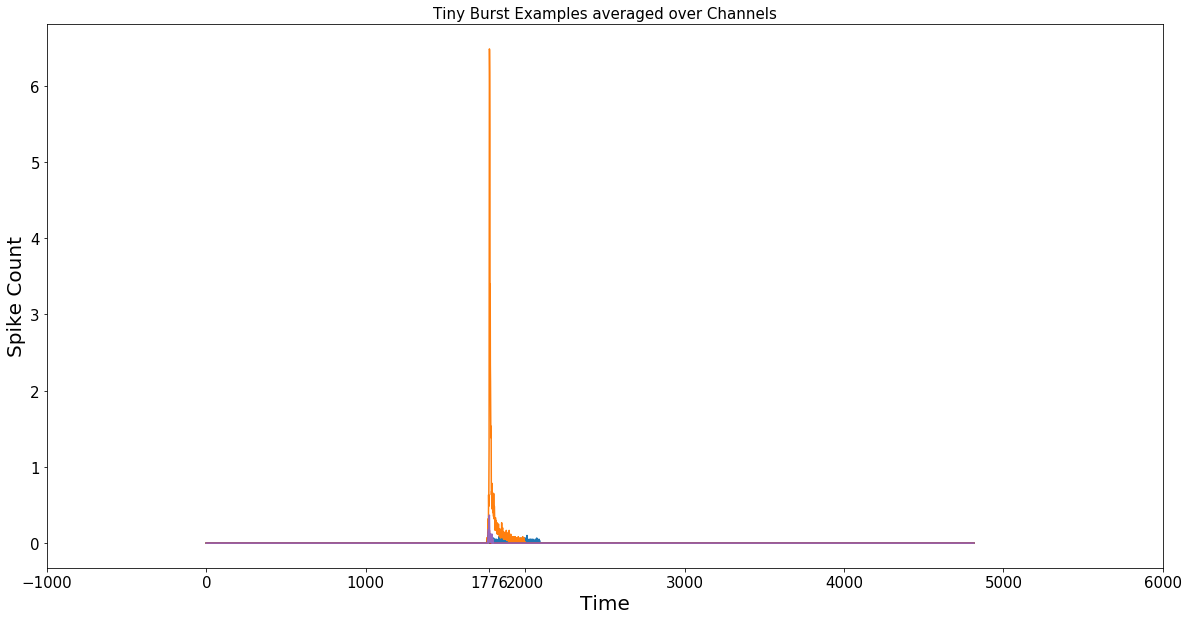

In [0]:
plt.figure(figsize=(20,10))
for burst in data_burst_by_time_shuffled_no_tiny.T[0:5]:
    plt.plot(burst)
plt.xlabel("Time")
plt.ylabel("Spike Count")
plt.title("Tiny Burst Examples averaged over Channels")    
plt.xticks(list(plt.xticks()[0]) + [data_center_no_tiny])
plt.show()

Text(0, 0.5, 'Score')

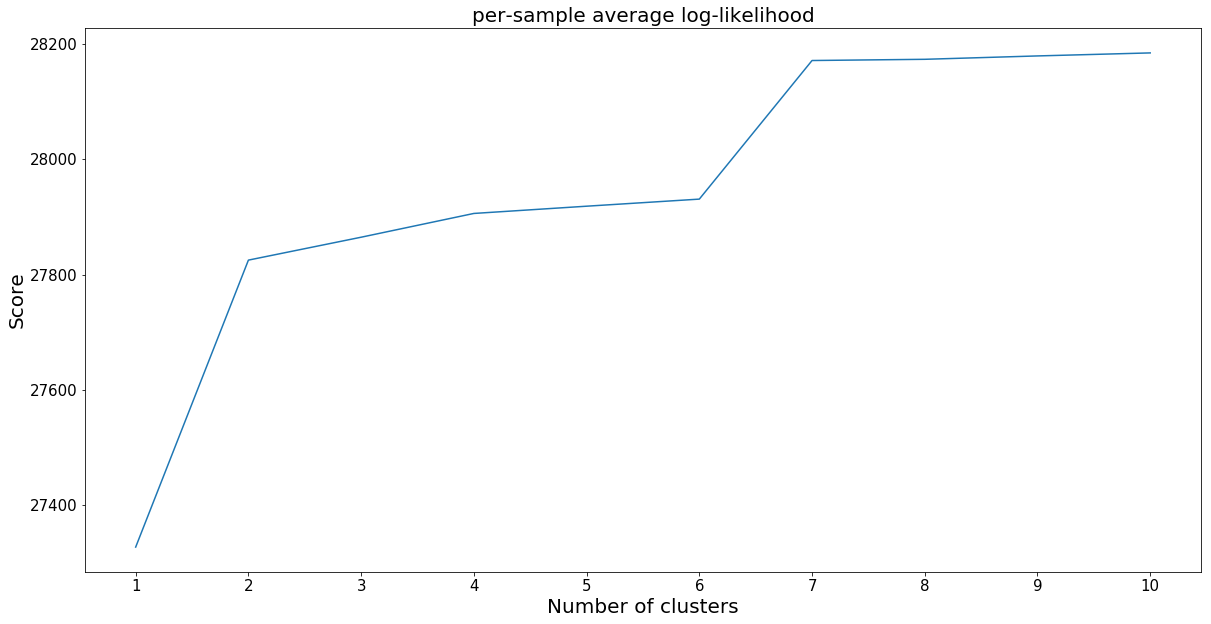

In [0]:
plt.figure(figsize = (20,10))
plt.plot(clusters,scores, label='BIC')
plt.title("per-sample average log-likelihood", fontsize=20)
plt.xticks(clusters)
plt.xlabel("Number of clusters")
plt.ylabel("Score")

In [0]:
print(bics)

[-147466150.6708932, -100285656.41070056, -50785369.03382483, -1360148.5015945137, 48193801.50419846, 97193122.37341934, 146744511.6128292, 196301650.04534167, 244048053.53308582, 295396889.01293004, 344923767.72123265, 392657686.6096116, 442215692.1944171, 493595926.122406, 541342009.3332913, 590896082.1841935, 640463737.458621, 690017723.4962811]


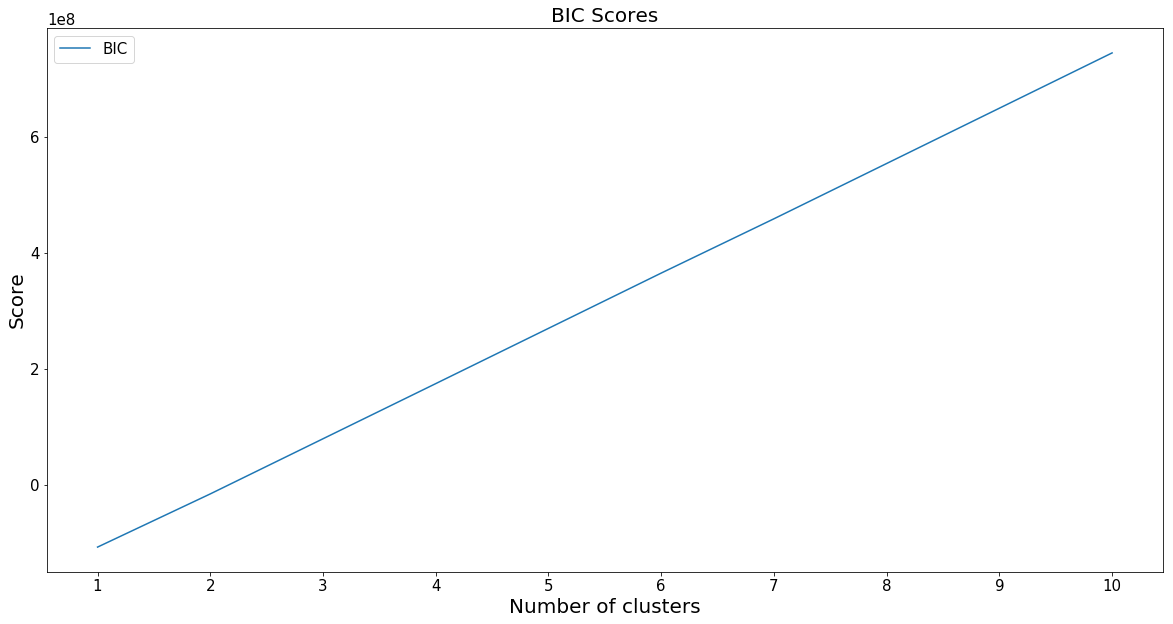

In [0]:
plot_bic_scores(bics,clusters,gradient_plot = False)

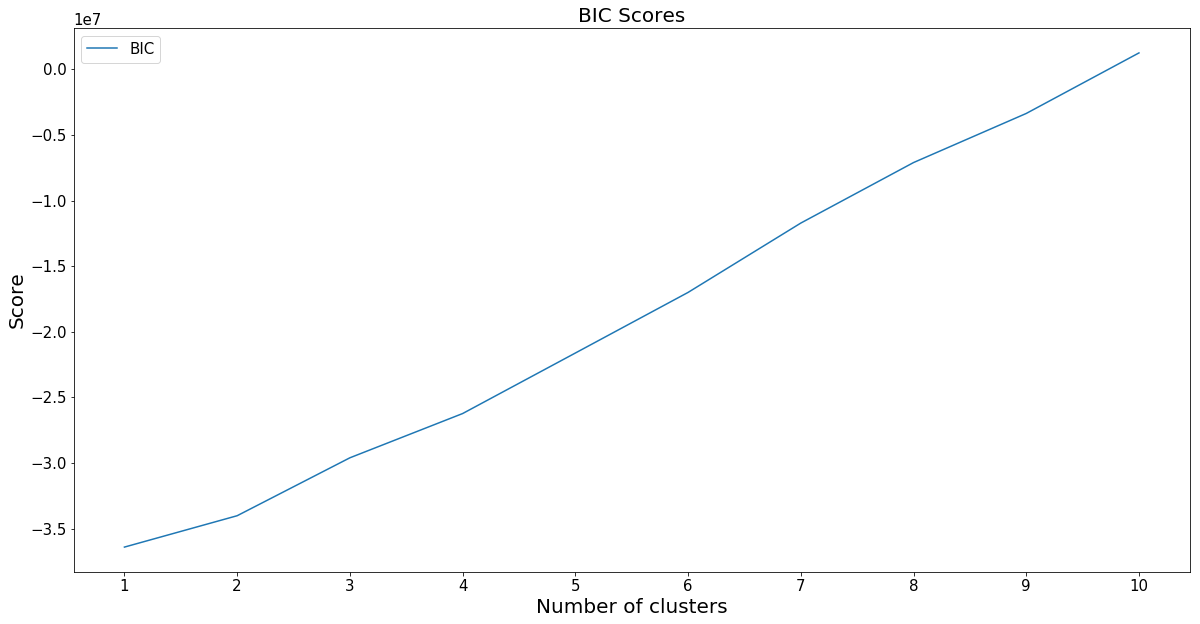

In [0]:
bics = [-36401384.60101375, -34011239.319,-29597275.569,-26225512.741,-21613935.215, -16994618.433, -11710874.466, -7099687.963, -3357174.217,1256296.246]
clusters = [1,2,3,4,5,6,7,8,9,10]
plot_bic_scores(bics,clusters,gradient_plot = False)

In [0]:
clusters = [2]
best_gmm, best_n_clusters, lowest_bic, bics, scores = validate_gmm_models(data_burst_by_time_shuffled.T, clusters,n_init=10) 

Fitting GMM with 2 clusters


In [0]:
gmm_labels = best_gmm.predict(data_burst_by_time_shuffled.T) 
plot_cluster_representatives(data_burst_by_time_shuffled.T,gmm_labels,best_n_clusters)

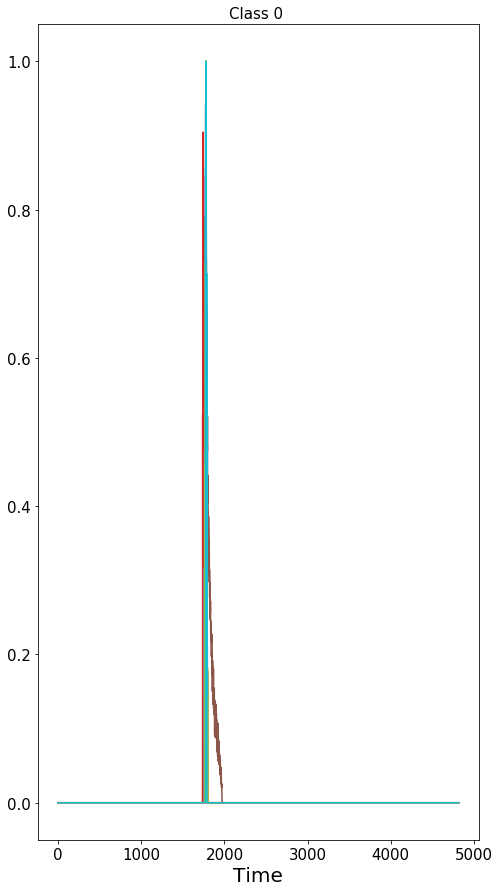

In [0]:
plot_normalized_cluster_examples(data_burst_by_time_shuffled.T,gmm_labels,best_n_clusters)

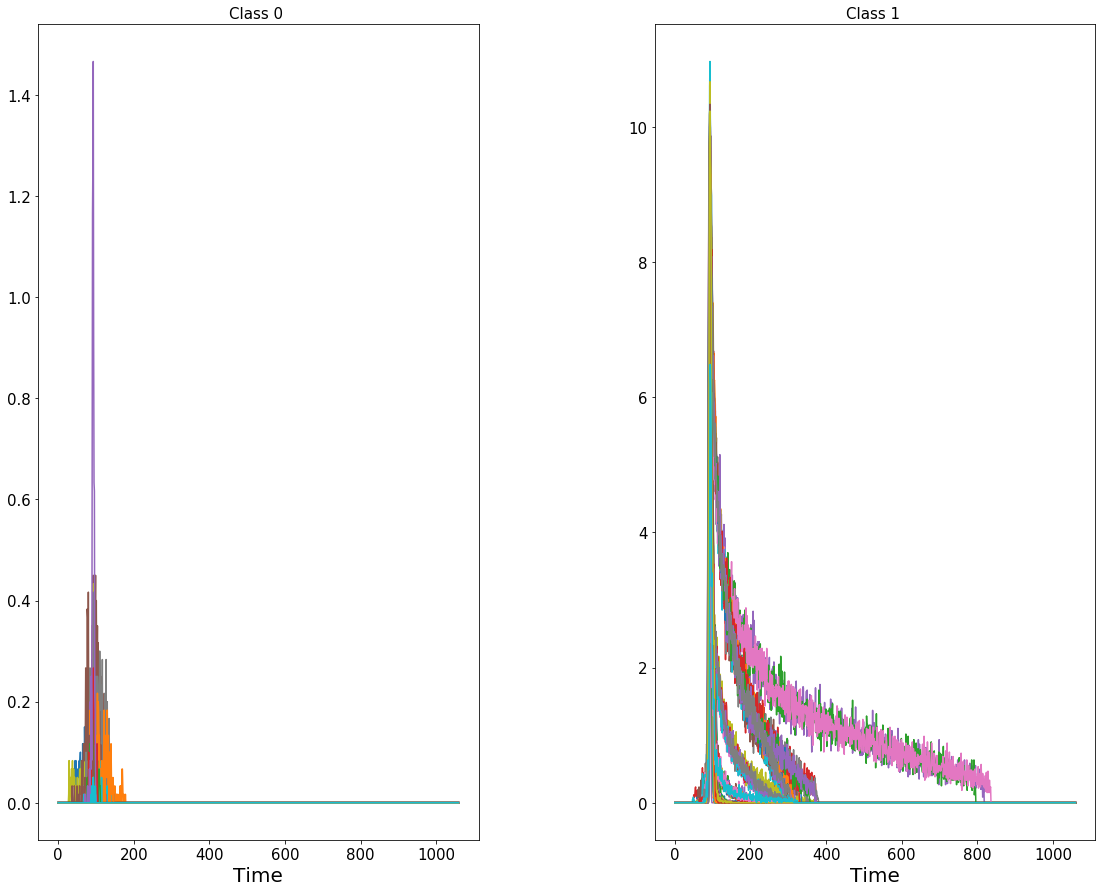

In [0]:
if best_n_clusters < 10:
    colors = ["C" + str(i) for i in range(best_n_clusters)]
else:
    colors = cm.rainbow(np.linspace(0, 1, best_n_clusters))

fig = plt.figure(figsize=(30,15))
fig.subplots_adjust(hspace=0.4, wspace=0.4)    
rows = int(np.ceil(best_n_clusters/3)) 
for i in range(best_n_clusters):
    class_i = burst_data[np.where(gmm_labels == i)]
    class_i = np.random.permutation(class_i)
    if i < best_n_clusters:
        count = i + 1
    ax = fig.add_subplot(rows, 3, count)
    ax.set_xlabel("Time")
    ax.set_title("Class %i " % i)
    for burst in class_i[0:100]:
        ax.plot(burst)

In [0]:
culture_counts = [141, 531, 128, 194, 1782, 2112, 1656, 554, 235, 661, 143, 142, 2853, 61, 338, 231, 30, 156, 270, 416, 77, 96, 285]
culture_names = ["C11","C12","C15","C21","C22","C23","C24","C25,""C26","C31","C32", "C33", "C34","C35","C36", "C51","C52","C53","C71","C72", "C81","C82","C83"]


#burst_data_batch_1_1_20 141
#burst_data_batch_1_2_20 531
#burst_data_batch_1_5_20 128
#burst_data_batch_2_1_20 194
#burst_data_batch_2_2_20 1782
#burst_data_batch_2_3_20 2112
#burst_data_batch_2_4_20 1656
#burst_data_batch_2_5_20 554
#burst_data_batch_2_6_20 235
#burst_data_batch_3_1_20 661
#burst_data_batch_3_2_20 143
#burst_data_batch_3_3_20 142
#burst_data_batch_3_4_20 2853
#burst_data_batch_3_5_20 61
#burst_data_batch_3_6_20 338
#burst_data_batch_5_1_20 231
#burst_data_batch_5_2_20 30
#burst_data_batch_5_3_20 156
#burst_data_batch_7_1_20 270
#burst_data_batch_7_2_20 416
#burst_data_batch_8_1_20 77
#burst_data_batch_8_2_20 96
#burst_data_batch_8_3_20 285

/usr/local/lib/python3.5/dist-packages/pandas/core/computation/check.py:19: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.6.1

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


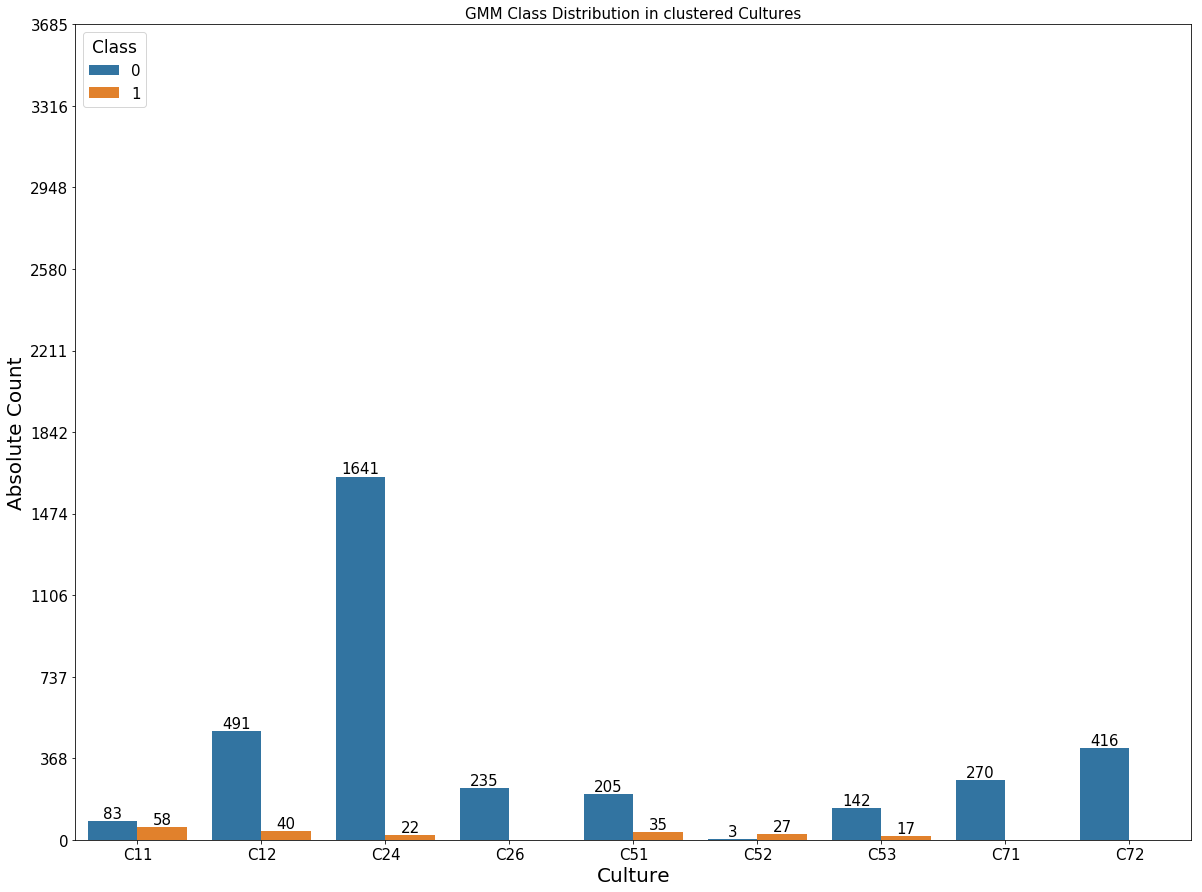

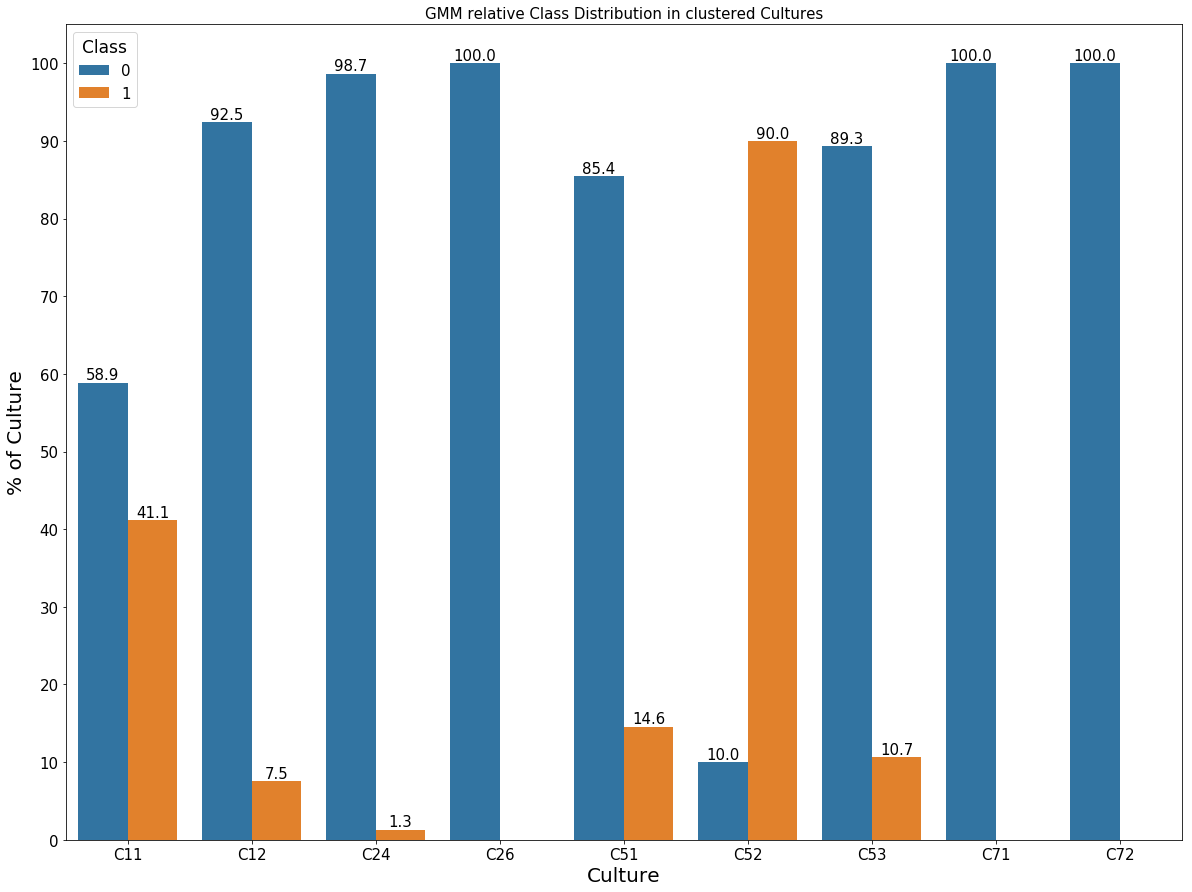

In [0]:
plot_class_counts(culture_counts, culture_names, gmm_labels)

## Spectral Clustering

In [0]:
print(data_burst_by_time.shape)

(13092, 3410)


In [0]:
dataset_cutted = data_burst_by_time[:,1000:2500] # 1. cut 1000 - 2500 2. cut 1200 - 2200
dataset_cutted2 = data_burst_by_time[:,1200:2200]
print("First Cut: ", dataset_cutted.shape)
print("Second Cut: ", dataset_cutted2.shape)

First Cut:  (13092, 1500)
Second Cut:  (13092, 1000)


### Cross Validation Split:

In [0]:
#culture_counts = [141, 531, 1656, 235, 231, 30, 156, 270, 416]
#culture_names = ["C11","C12","C24","C26","C51","C52","C53","C71","C72"]
culture_counts = [141, 531, 128, 194, 1782, 2112, 1656, 554, 235, 661, 143, 142, 2853, 61, 338, 231, 30, 156, 270, 416, 77, 96, 285]
culture_names = ["C11","C12","C15","C21","C22","C23","C24","C25","C26","C31","C32", "C33", "C34","C35","C36", "C51","C52","C53","C71","C72","C81","C82","C83"]
print(len(culture_counts))
print(len(culture_names))

23
23


In [0]:
cultures = []
for i,culture in enumerate(culture_names):
  cultures += list(np.repeat(culture, culture_counts[i]))

In [0]:
np.random.seed(6)

training_split = []
culture_border = np.sort(np.append(np.cumsum(culture_counts),0))

for i,culture_count in enumerate(culture_counts):
  if i+1 < len(culture_border):
    training_split_index = np.random.choice(np.arange(culture_border[i], culture_border[i+1]), int(0.75*culture_count),replace=False)
    training_split += list(training_split_index)
    
training_split = np.sort(training_split)  
test_split = np.delete(np.arange(0,len(cultures)), training_split)

In [0]:
training_set = data_burst_by_time[training_split] #dataset_cutted2[training_split] #data_burst_by_time[training_split]
test_set = data_burst_by_time[training_split] #dataset_cutted2[test_split] #data_burst_by_time[test_split]

In [0]:
print(0.75 * len(cultures))
print(np.cumsum(culture_counts))

9819.0
[  141   672   800   994  2776  4888  6544  7098  7333  7994  8137  8279
 11132 11193 11531 11762 11792 11948 12218 12634 12711 12807 13092]


In [0]:
from sklearn.metrics import pairwise_distances
eucl_distances = pairwise_distances(training_set,training_set, metric = "euclidean")
sorted_eucl_dist_indices = np.argsort(eucl_distances, axis = 1)

In [0]:
#n = data_burst_by_time.shape[0] 
n = training_set.shape[0]
print(training_set.shape)

(9810, 3410)


In [0]:
sigma = 1
aff_matrix = np.exp(-0.5 * sigma**2 * eucl_distances**2)
sorted_aff_indices = np.argsort(aff_matrix, axis = 1) 
#np.allclose(aff_matrix,aff_matrix.T,rtol=1e-05, atol=1e-08)

In [0]:
sparsity = 1.0 - np.count_nonzero(data_burst_by_time) / data_burst_by_time.size
print(sparsity)

0.9936333486546371


In [0]:
data_burst_by_time_sparse = scipy.sparse.csr_matrix(data_burst_by_time)

In [0]:
from sklearn.metrics import pairwise_distances
eucl_distances = pairwise_distances(dataset_cutted2,dataset_cutted2, metric = "euclidean")
sorted_eucl_dist_indices = np.argsort(eucl_distances, axis = 1)

In [0]:
n = dataset_cutted2.shape[0]#data_burst_by_time.shape[0]
print(np.log(n))

9.47975663562107


In [0]:
sigma = 1
aff_matrix = np.exp(-0.5 * sigma**2 * eucl_distances**2)
sorted_aff_indices = np.argsort(aff_matrix, axis = 1) 
#np.allclose(aff_matrix,aff_matrix.T,rtol=1e-05, atol=1e-08)

In [0]:
from sklearn.metrics import pairwise_distances
manhattan_distances = pairwise_distances(training_set,training_set, metric = "manhattan")
sorted_manh_dist_indices = np.argsort(manhattan_distances, axis = 1)

In [0]:
np.allclose(manhattan_distances,manhattan_distances.T,rtol=1e-05, atol=1e-08)

True

In [0]:
A = np.array([[1, 0, 0, 0.5], [0, 1, 0.2, 0.3], [0, 0.1, 1, 0.2]])
x0 = np.array([1, 0, 1, 0], dtype='f8')  # Original signal
y = A.dot(x0)                            # noise free signal
lmbda = 0.001                          # regularization parameter
rel_tol = 0.01

[x, status, hist] = L.l1ls_nonneg(A, y, lmbda, tar_gap=rel_tol)
# answer_x = np.array([0.993010, 0.00039478, 0.994096, 0.00403702])


Solving a problem of size (m=3, n=4), with lambda=1.000000e-03
----------------------------------------------------------------------
 iter       gap         primobj         dualobj      step len
   0     6.18e+00     2.03400e+00    -4.15000e+00         inf
   1     2.08e+00     5.10917e-01    -1.56808e+00     5.0e-01
   2     7.88e-01     1.30190e-01    -6.57807e-01     5.0e-01
   3     3.33e-01     3.49666e-02    -2.97641e-01     5.0e-01
   4     1.53e-01     1.11760e-02    -1.41550e-01     5.0e-01
   5     2.81e-03     2.40798e-03    -4.05113e-04     1.0e+00
   6     1.71e-03     2.35883e-03     6.44682e-04     1.0e+00
   7     9.29e-04     2.21723e-03     1.28807e-03     1.0e+00
   8     4.80e-04     2.11795e-03     1.63799e-03     1.0e+00
   9     2.38e-04     2.05882e-03     1.82074e-03     1.0e+00
  10     1.19e-04     2.02992e-03     1.91071e-03     1.0e+00
  11     5.96e-05     2.01515e-03     1.95559e-03     1.0e+00
  12     2.97e-05     2.00758e-03     1.97787e-03     1.0e+

In [0]:
print(x)

[9.97867072e-01 8.70378443e-04 9.98452598e-01 3.26977002e-03]


In [0]:
n = data_burst_by_time.shape[0]
lmbda = 0.1                             # regularization parameter
rel_tol = 0.1
#A_spars = np.zeros((n,n))
print(n)

13092


In [0]:
saved_A_sparse_files = [x for x in os.listdir('/content/gdrive/My Drive/Burst_data') if x.find("A_spars_neg") >= 0]
saved_A_sparse_files = np.sort(saved_A_sparse_files)
latest_checkpoint = saved_A_sparse_files[-1]
latest_iteration = latest_checkpoint.split(".")[0].split("_")[-1]
print(saved_A_sparse_files)
A_spars = np.load('/content/gdrive/My Drive/Burst_data/A_spars_neg10000.npy')
print(A_spars.shape)

['A_spars_neg10000.npy' 'A_spars_neg9000.npy']
(13092, 13092)


In [0]:
for i in range(10001,13092):
  X_i = scipy.sparse.csr_matrix(np.delete(data_burst_by_time,i,0).T)
  y_i = data_burst_by_time[i].T
  [a_i, status, hist] = L.l1ls(X_i, y_i, lmbda, tar_gap=rel_tol, quiet=True)
  A_spars[i] = np.insert(a_i,i,0,axis=0)
  if i % 100 == 0:
    print("Solved L1 least-squares for burst %d..." % i)
  if i % 1000 == 0 or i == n-1:
    np.save('/content/gdrive/My Drive/Burst_data/A_spars_neg' + str(i),A_spars)

Solved L1 least-squares for burst 10100...
Solved L1 least-squares for burst 10200...
Solved L1 least-squares for burst 10300...
Solved L1 least-squares for burst 10400...
Solved L1 least-squares for burst 10500...
Solved L1 least-squares for burst 10600...
Solved L1 least-squares for burst 10700...
Solved L1 least-squares for burst 10800...
Solved L1 least-squares for burst 10900...
Solved L1 least-squares for burst 11000...
Solved L1 least-squares for burst 11100...
Solved L1 least-squares for burst 11200...
Solved L1 least-squares for burst 11300...
Solved L1 least-squares for burst 11400...
Solved L1 least-squares for burst 11500...
Solved L1 least-squares for burst 11600...
Solved L1 least-squares for burst 11700...
Solved L1 least-squares for burst 11800...
Solved L1 least-squares for burst 11900...
Solved L1 least-squares for burst 12000...
Solved L1 least-squares for burst 12100...
Solved L1 least-squares for burst 12200...
Solved L1 least-squares for burst 12300...
Solved L1 l

In [0]:
saved_A_sparse_files = [x for x in os.listdir('/content/gdrive/My Drive/Burst_data') if x.find("A_spars_neg") >= 0]
saved_A_sparse_files = np.sort(saved_A_sparse_files)
print(saved_A_sparse_files)
A_spars = np.load('/content/gdrive/My Drive/Burst_data/A_spars_neg13091.npy')
A_spars_non_neg = np.load(('/content/gdrive/My Drive/Burst_data/A_spars_13091.npy'))

['A_spars_neg10000.npy' 'A_spars_neg11000.npy' 'A_spars_neg12000.npy'
 'A_spars_neg13000.npy' 'A_spars_neg13091.npy' 'A_spars_neg9000.npy']


In [0]:
COS = sklearn.metrics.pairwise.cosine_similarity(A_spars)
COS = np.maximum(np.zeros((COS.shape[0], COS.shape[1])), COS)
sorted_COS_indices = np.argsort(COS, axis = 1)

NameError: ignored

In [0]:
n = data_burst_by_time.shape[0]
NN = np.zeros((n,n)) # nonnegative sparsity induced similarity measure (NN) 
for i in range(n):
  if i%1000 == 0:
    print("Step: ", i)
  row_sum = np.sum(A_spars_non_neg[i])
  NN[i] = A_spars_non_neg[i]/row_sum

Step:  0
Step:  1000
Step:  2000
Step:  3000
Step:  4000
Step:  5000
Step:  6000
Step:  7000
Step:  8000
Step:  9000
Step:  10000
Step:  11000
Step:  12000
Step:  13000


In [0]:
sorted_NN_indices = np.argsort(NN, axis = 1)

In [0]:
saved_CSS_files = [x for x in os.listdir('/content/gdrive/My Drive/Burst_data') if x.find("CSS") >= 0]
print(saved_CSS_files)
CSS = np.load('/content/gdrive/My Drive/Burst_data/CSS85693686.npy')

['CSS85693686.npy']


In [0]:
sorted_CSS_indices = np.argsort(CSS, axis = 1)

In [0]:
dist_array = COS[np.triu_indices(13092, k = 1)]

In [0]:
def plot_distance_distribution(distance_array, bins = 30, title = "", xlim = None):
    
    plt.rc('xtick',labelsize=25)
    plt.rc('ytick',labelsize=25)
    fig, ax = plt.subplots(figsize = (40,20))
    counts, bins, patches = plt.hist(distance_array,bins = bins)
    max_count = max(counts)
    
    bin_centers = 0.5 * np.diff(bins) + bins[:-1]
    
        
    for count, x in zip(counts, bin_centers):
        if xlim and x > xlim[1]:
            break
        if count == max_count:
            xy = (x, count/max_count + 0.02)
        else:
            xy = (x, count/max_count + 0.06)
        percent = '%0.1f%%' % (100 * float(count) / counts.sum())
        ax.annotate(percent, xy=xy, xycoords=('data', 'axes fraction'),
            xytext=(0, -32), textcoords='offset points', va='top', ha='center', fontsize = 25)
    
    
        
    ax.set_xticks(np.round(bins,1))
    if xlim:
        ax.set_xlim(xlim)
    
        
    # Give ourselves some more room at the bottom of the plot
    plt.subplots_adjust(bottom=0.15)
    plt.title(title, fontsize = 40)

In [0]:
def construct_knn_graph(matrix,sorted_indices,k=10, mutual = False, weighted = None):
  A = np.zeros(matrix.shape)
  if mutual: # knn graph only when among both knn connect
    for i, indices in enumerate(sorted_indices):
      if weighted == "similarity":
        k_nearest = indices[-(k+1) : -1]
      else:
        k_nearest = indices[1:k+1]    
      for j in k_nearest: 
        if i in sorted_indices[j,1:k+1]:
          if weighted:
            A[i,j] = matrix[i,j]
          else:
            A[i,j] = 1
  else:
    for i,indices in enumerate(sorted_indices): 
        if weighted == "similarity":
          k_nearest = indices[-(k+1) : -1]
          A[i,k_nearest] = matrix[i,k_nearest]
          A[k_nearest,i] = matrix[k_nearest,i]
        else:
          k_nearest = indices[1:k+1]
          if weighted=="distance":
            A[i,k_nearest] = matrix[i,k_nearest]
            A[k_nearest,i] = matrix[k_nearest,i]
          else:
            A[i,k_nearest] = 1
            A[k_nearest, i] = 1
  return A

In [0]:
A = construct_knn_graph(eucl_distances,sorted_eucl_dist_indices, k=5, mutual=False,weighted="distance")

In [0]:
n = dataset_cutted2.shape[0]
print(n)

13092


In [0]:
A = A + 0.1/n * np.ones((n,n))

In [0]:
D = np.sum(A,axis = 1)
D_inv_sqrt = np.reciprocal(np.sqrt(D))
D_inv_sqrt[np.where(np.isinf(D_inv_sqrt))] = 0
D = np.diag(D)
D_inv_sqrt = np.diag(D_inv_sqrt)

In [0]:
L = D - A
L_norm =  D_inv_sqrt @ L @ D_inv_sqrt

In [0]:
D = np.sum(A,axis = 1)
L_rw = np.diag(np.reciprocal(D))

In [0]:
print(np.sum(A,axis = 1))

[2.4405763  2.94839673 6.03568738 ... 5.         5.         4.87546888]


In [0]:
eigval, eigvec  = scipy.linalg.eigh(L_norm)
idx = eigval .argsort()#[::-1]   
eigval = eigval[idx]#.astype("float")
eigvec = eigvec[:,idx]#.astype("float")
print(eigval)

[-9.66216193e-17  2.59597945e-03  2.71655923e-03 ...  1.64670074e+00
  1.65705670e+00  1.66647574e+00]


In [0]:
print(len(eigval))

9810


In [0]:
np.save('/content/gdrive/My Drive/Burst_data/eigenvalues_euclid_k=5_regularized=0.1_cutted2',eigval)
np.save('/content/gdrive/My Drive/Burst_data/eigenvectors_euclid_k=5_regularized=0.1_cutted2',eigvec)

In [0]:
eigval = np.load('/content/gdrive/My Drive/Burst_data/eigenvalues_euclid_k=5_regularized=0.1_cutted2.npy')
eigvec = np.load('/content/gdrive/My Drive/Burst_data/eigenvectors_euclid_k=5_regularized=0.1_cutted2.npy')

18 0.05974155351834985


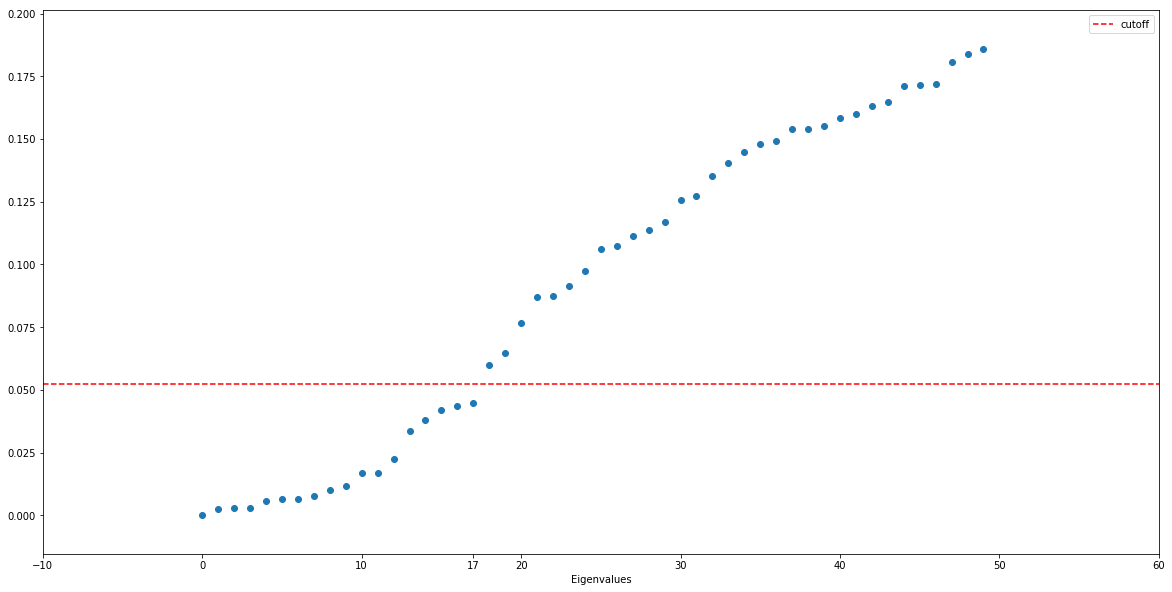

In [0]:
cutoff = 18#np.where(eigval >= 0.0)[0][0] 
print(cutoff, eigval[cutoff])
plt.figure(figsize=(20,10))
#plt.scatter(range(len(eigval)),eigval)
plt.scatter(range(50),eigval[0:50])
#plt.scatter(range(50),eigval[1075:1125])
plt.axhline(eigval[cutoff-1] + (eigval[cutoff]-eigval[cutoff-1])/2, c="red", linestyle = "--", label = "cutoff")
plt.xticks(list(plt.xticks()[0]) + [cutoff-1] )
#plt.xticks([1000,2000,4000,8000,10000,12000]+ [cutoff-1])
plt.xlabel("Eigenvalues")
plt.ylabel("")
plt.legend()
plt.show()

In [0]:
U = eigvec[:,:cutoff]
U = U.astype("float")
T = sklearn.preprocessing.normalize(U, norm='l2')
print(U.shape)

(13092, 18)


In [0]:
from sklearn.cluster import KMeans
X = T
n_clusters = cutoff 
kmeans = KMeans(n_clusters=n_clusters).fit(X)
labels = kmeans.labels_
print(labels)

[16 16  0 ...  0  0  0]


In [0]:
centers = kmeans.cluster_centers_ 

In [0]:
#np.save('/content/gdrive/My Drive/Burst_data/k_means_centers_cutted',centers)
np.save('/content/gdrive/My Drive/Burst_data/labels_cutted_data2',labels)

In [0]:
print(np.unique(labels))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


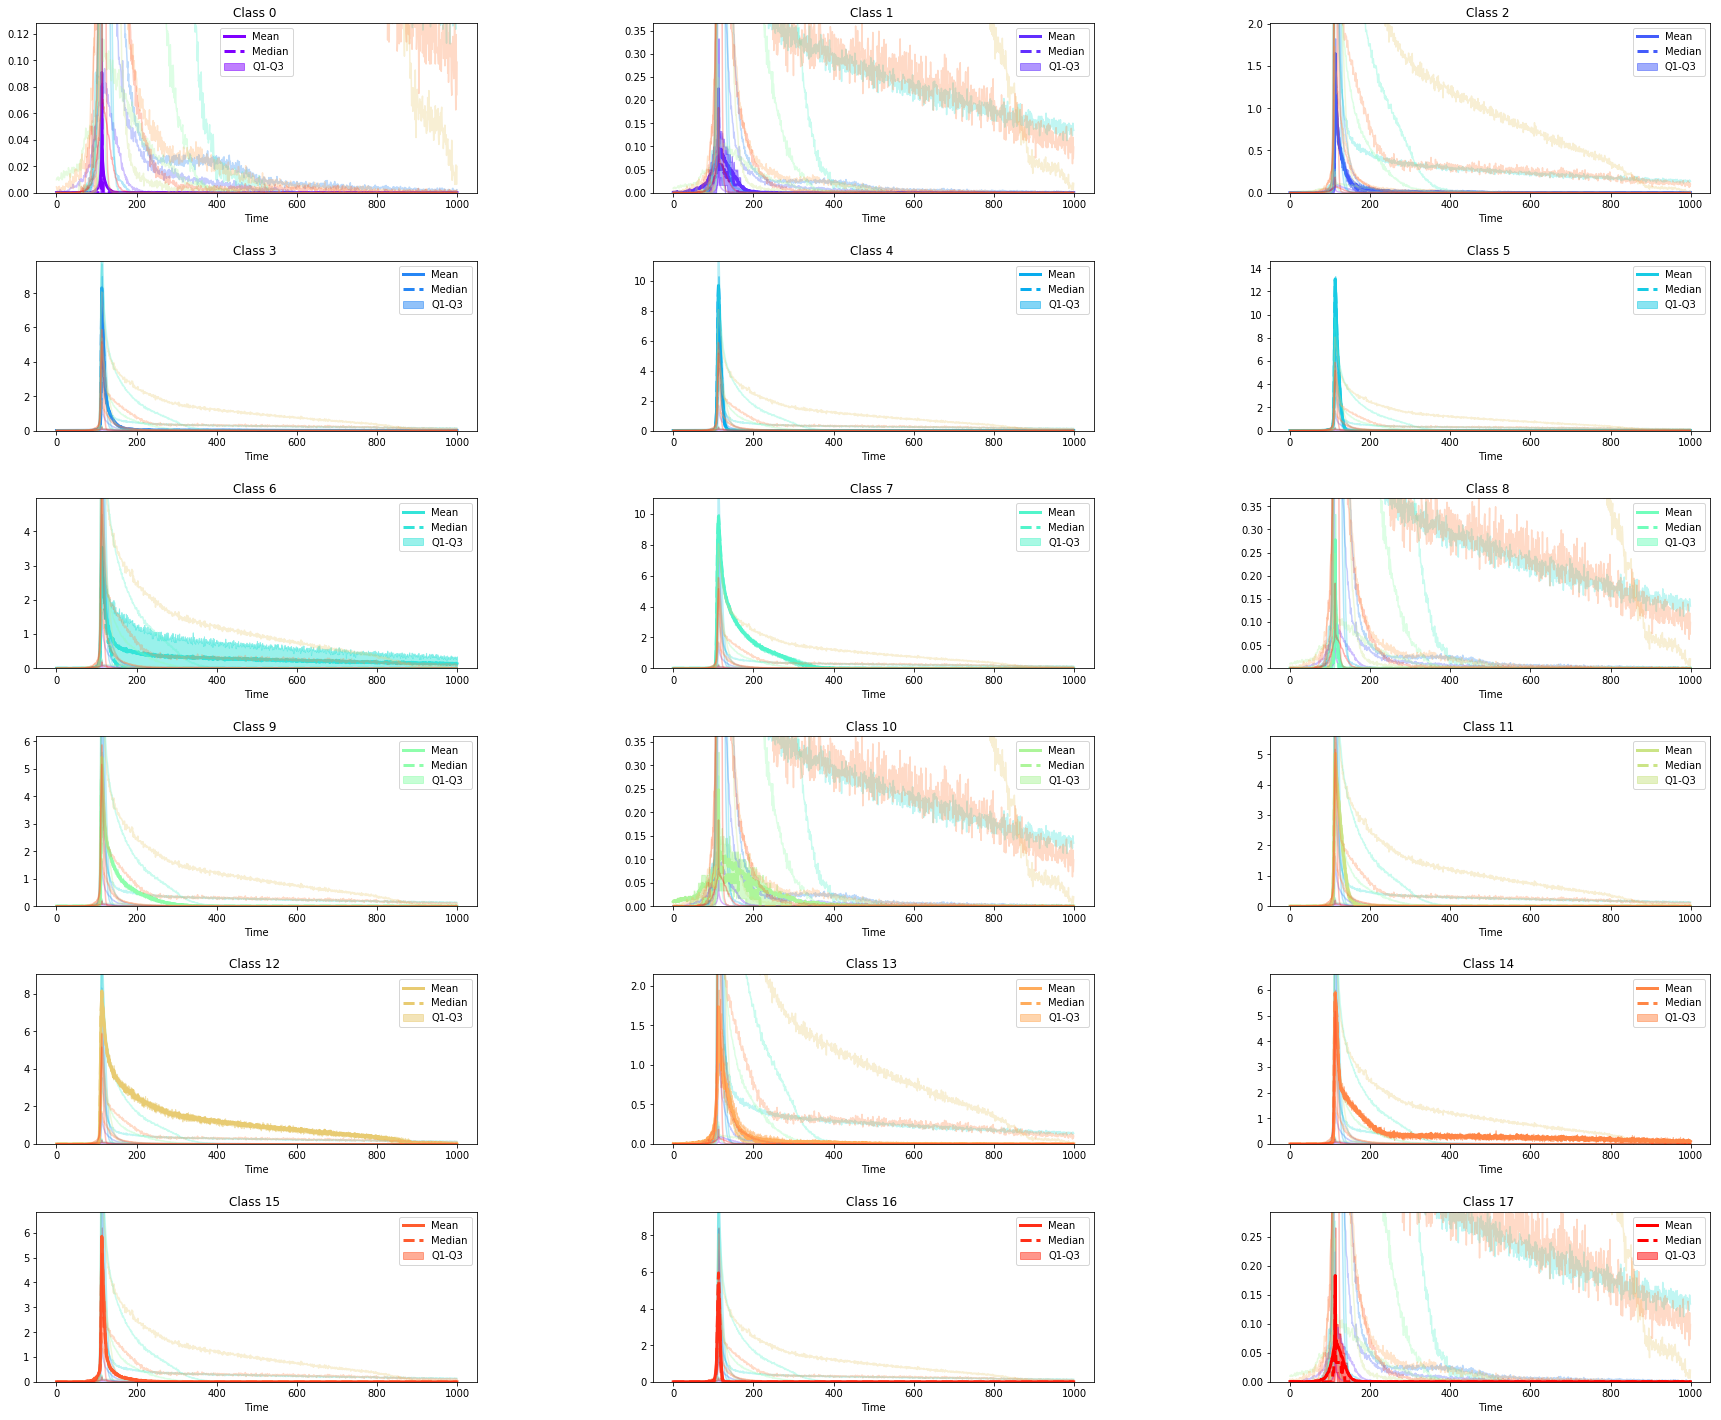

In [0]:
plot_cluster_representatives(dataset_cutted2,labels,cutoff,figsize=(30,25))  # dataset_cutted

In [0]:
plot_normalized_cluster_examples(burst_data,labels,25)

NameError: ignored

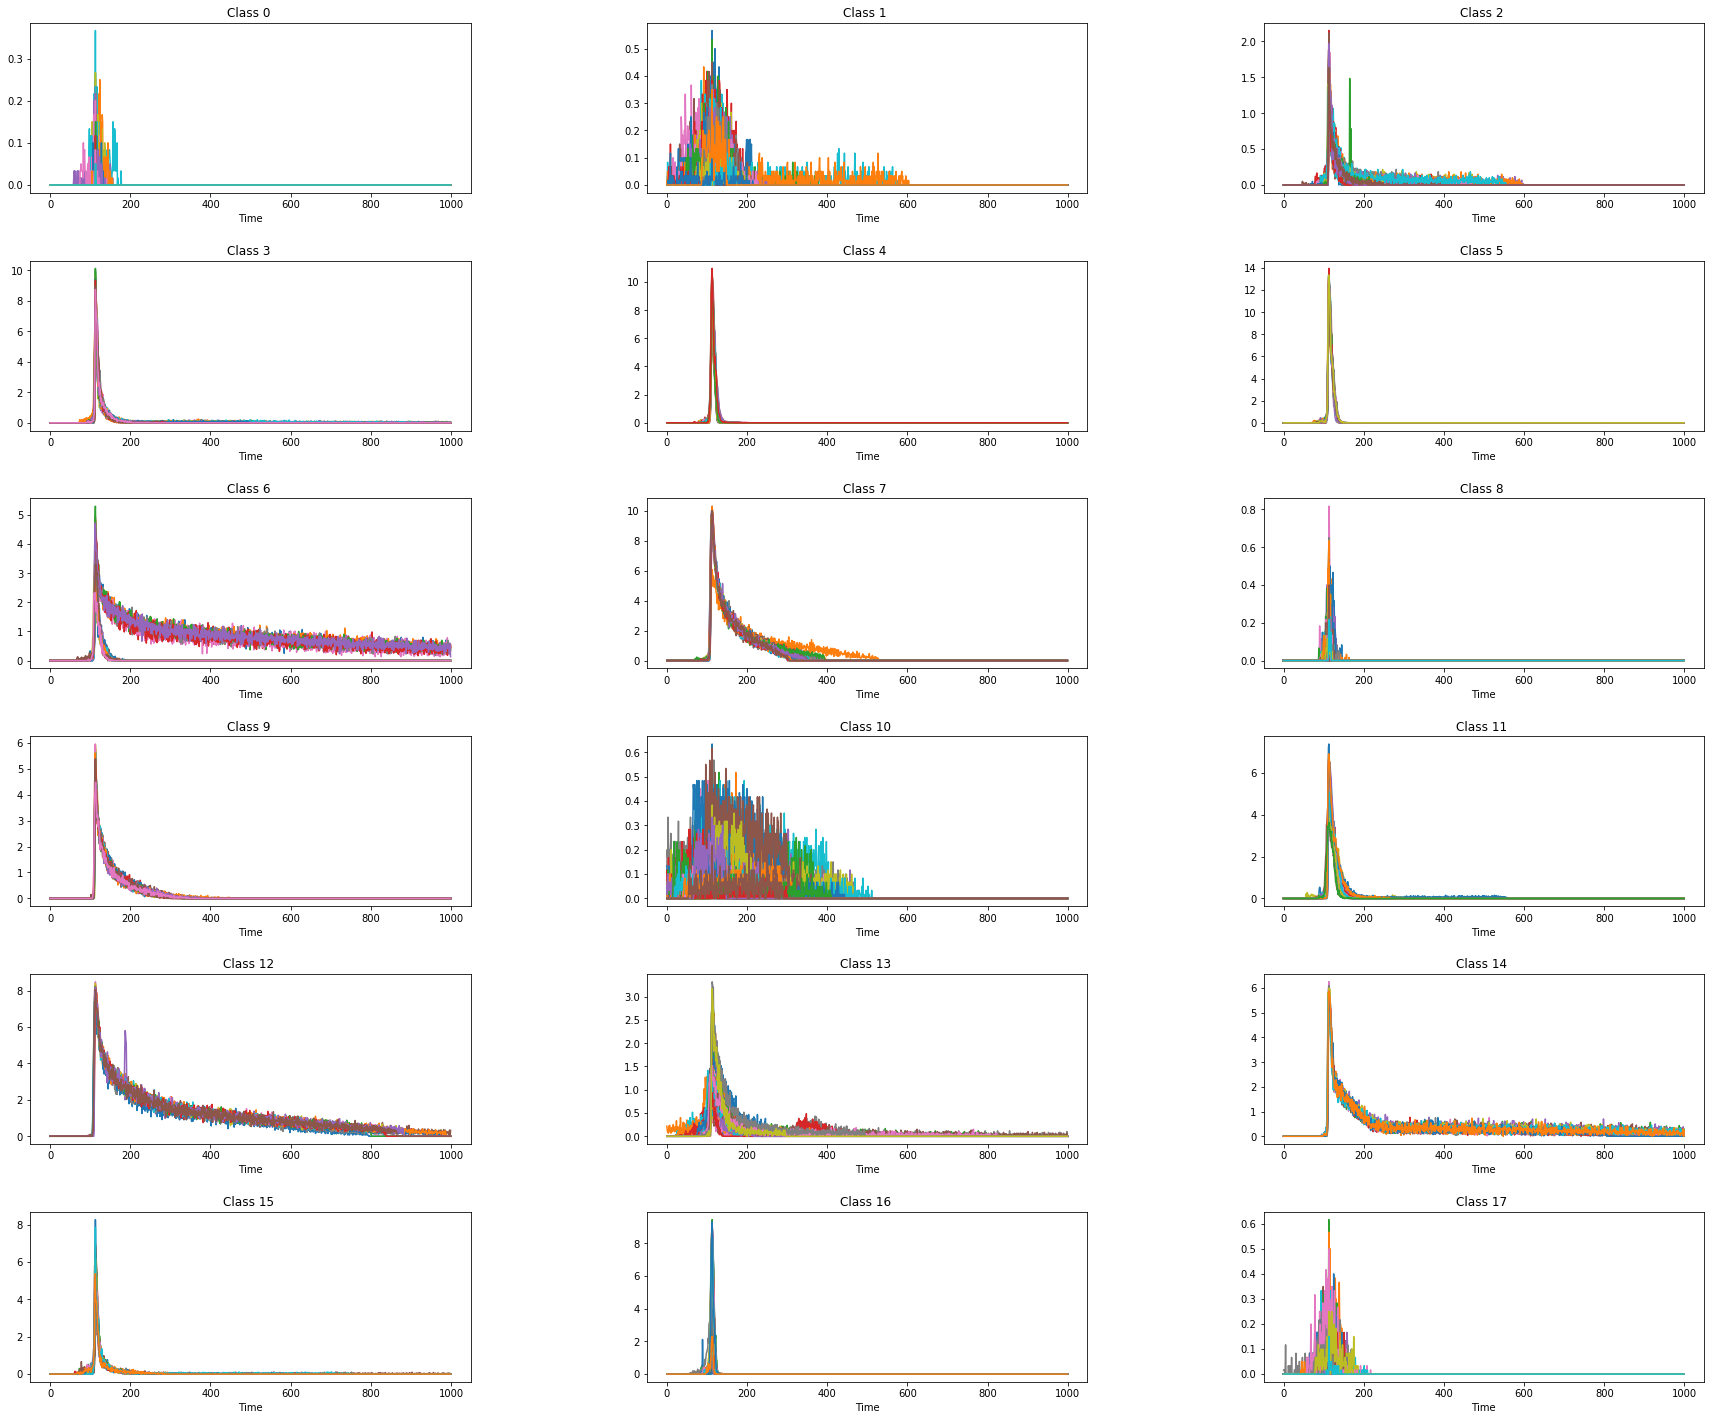

In [0]:
#cutoff = 20
if cutoff < 10:
    colors = ["C" + str(i) for i in range(cutoff)]
else:
    colors = cm.rainbow(np.linspace(0, 1, cutoff))

fig = plt.figure(figsize=(30,25))
fig.subplots_adjust(hspace=0.4, wspace=0.4)    
rows = int(np.ceil(cutoff/3)) 
for i in range(cutoff):
    class_i = dataset_cutted2[np.where(labels == i)] #dataset_cutted # data_burst_by_time
    class_i = np.random.permutation(class_i)
    if i < cutoff:
        count = i + 1
    ax = fig.add_subplot(rows, 3, count)
    ax.set_xlabel("Time")
    ax.set_title("Class %i " % i)
    for burst in class_i[0:200]:
        ax.plot(burst)

In [0]:
labels = np.load('/content/gdrive/My Drive/Burst_data/labels.npy')
labels_cutted = np.load('/content/gdrive/My Drive/Burst_data/labels_cutted_data.npy')
labels_cutted2 = np.load('/content/gdrive/My Drive/Burst_data/labels_cutted_data2.npy')

In [0]:
centers = np.load('/content/gdrive/My Drive/Burst_data/k_means_centers.npy')
centers_cutted =  np.load('/content/gdrive/My Drive/Burst_data/k_means_centers_cutted.npy')
centers_cutted2 = np.load('/content/gdrive/My Drive/Burst_data/k_means_centers_cutted2.npy')

In [0]:
print(labels)
print(labels_cutted)
print(labels_cutted2)

[ 3  3 13 ... 13 13 13]
[3 3 0 ... 0 0 0]
[7 7 6 ... 6 6 6]


In [0]:
print(labels)

[16 16  0 ...  0  0  0]


In [0]:
label_dict = {}
#label_dict1 = {}
#label_dict2 = {}


for i in np.unique(labels):
  label_dict[i] = np.where(labels == i)
  #label_dict1[i] = np.where(labels_cutted == i)
  #label_dict2[i] = np.where(labels_cutted2 == i)

In [0]:
def calculate_overlapping_classes(label_dict_i, label_dict_j):
  class_overlap_keys = []
  class_overlap = []

  for key_i in np.unique(labels):
    class_i = label_dict_i[key_i][0]
    overlaps = []
    overlaps_percent = [] 
    for key_j in label_dict_j.keys():

      class_j = label_dict_j[key_j][0]
      #overlap = (np.sum(np.isin(class_i, class_j))/len(class_i) + np.sum(np.isin(class_j, class_i))/len(class_j))/2
      overlap = (np.sum(np.isin(class_i, class_j)) + np.sum(np.isin(class_j, class_i)))/2

      overlaps += [overlap]

    class_overlap_keys.append(np.argsort(overlaps)[-1]) # most overlapping class in label_dict1 
    class_overlap.append(np.asarray(overlaps)[np.argsort(overlaps)[-1]]) # corresponding overlap


  class_overlap_keys = np.asarray(class_overlap_keys)
  class_overlap = np.asarray(class_overlap)
  
  return class_overlap_keys, class_overlap

In [0]:
class_overlap_keys, class_overlap = calculate_overlapping_classes(label_dict, label_dict1)
class_overlap_keys2, class_overlap2 = calculate_overlapping_classes(label_dict, label_dict2)

In [0]:
print(class_overlap_keys2)
print(class_overlap2[np.where(class_overlap_keys == 0)[0]])

[ 0  5  4  7  2  1 13 10  9  3  8 12 11  6 15 16  0 17]
[8484.]


In [0]:
def label_mapping_based_on_overlap(label_dict, overlap_keys,overlap,n_classes):
  final_mapped_labels = np.zeros(18) # classes of original clustering
  mapped_dict = {}
  for i in range(n_classes):
    
    if not(i in overlap_keys):
      print(i)
      mapped_dict["-%d" % i] = label_dict[i] #class i has no corresponding mapping in first labeling (new class)
      #final_mapped_labels[i] = label  
      #mapped_dict[i] = label_dict1[label]
      
    else:
      mapped_to = np.where(overlap_keys == i)[0] # get index of mapped label
   
      if len(mapped_to) > 1:
        top_classes = overlap_keys[mapped_to]
        top_classes_overlap =  overlap[mapped_to]
        
        order = np.argsort(top_classes_overlap)
        
        for j, index in enumerate(order):
          if j == len(order)-1: #highest overlap
            final_mapped_labels[mapped_to[index]] = top_classes[index]
            mapped_dict[mapped_to[index]] = label_dict[top_classes[index]]
          else:
            final_mapped_labels[mapped_to[index]] = top_classes[index] + 0.1*(j+2) #indicate that same correspondance but smaller overlap 
            #mapped_dict[mapped_to[index]] = ([],)
            mapped_dict[mapped_to[index]] = label_dict[top_classes[index]]
      else:
        final_mapped_labels[mapped_to[0]] = i  
        mapped_dict[mapped_to[0]] = label_dict[i]
  
  return final_mapped_labels,mapped_dict

In [0]:
final_mapped_labels,mapped_dict = label_mapping_based_on_overlap(label_dict1, class_overlap_keys,class_overlap,18) ## mapped_dict keys are already mapped labels
final_mapped_labels2, mapped_dict2 = label_mapping_based_on_overlap(label_dict2, class_overlap_keys2,class_overlap2,18)

17
14


In [0]:
print(final_mapped_labels2)
print(np.sort(np.asarray(list(mapped_dict2.keys())).astype("int")))
print(np.sort(list(label_dict.keys())))
print()

[ 0.   5.   4.   7.   2.   1.  13.  10.   9.   3.   8.  12.  11.   6.
 15.  16.   0.2 17. ]
[-14   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
  17]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


19
(19, 3)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, -17]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, -14]


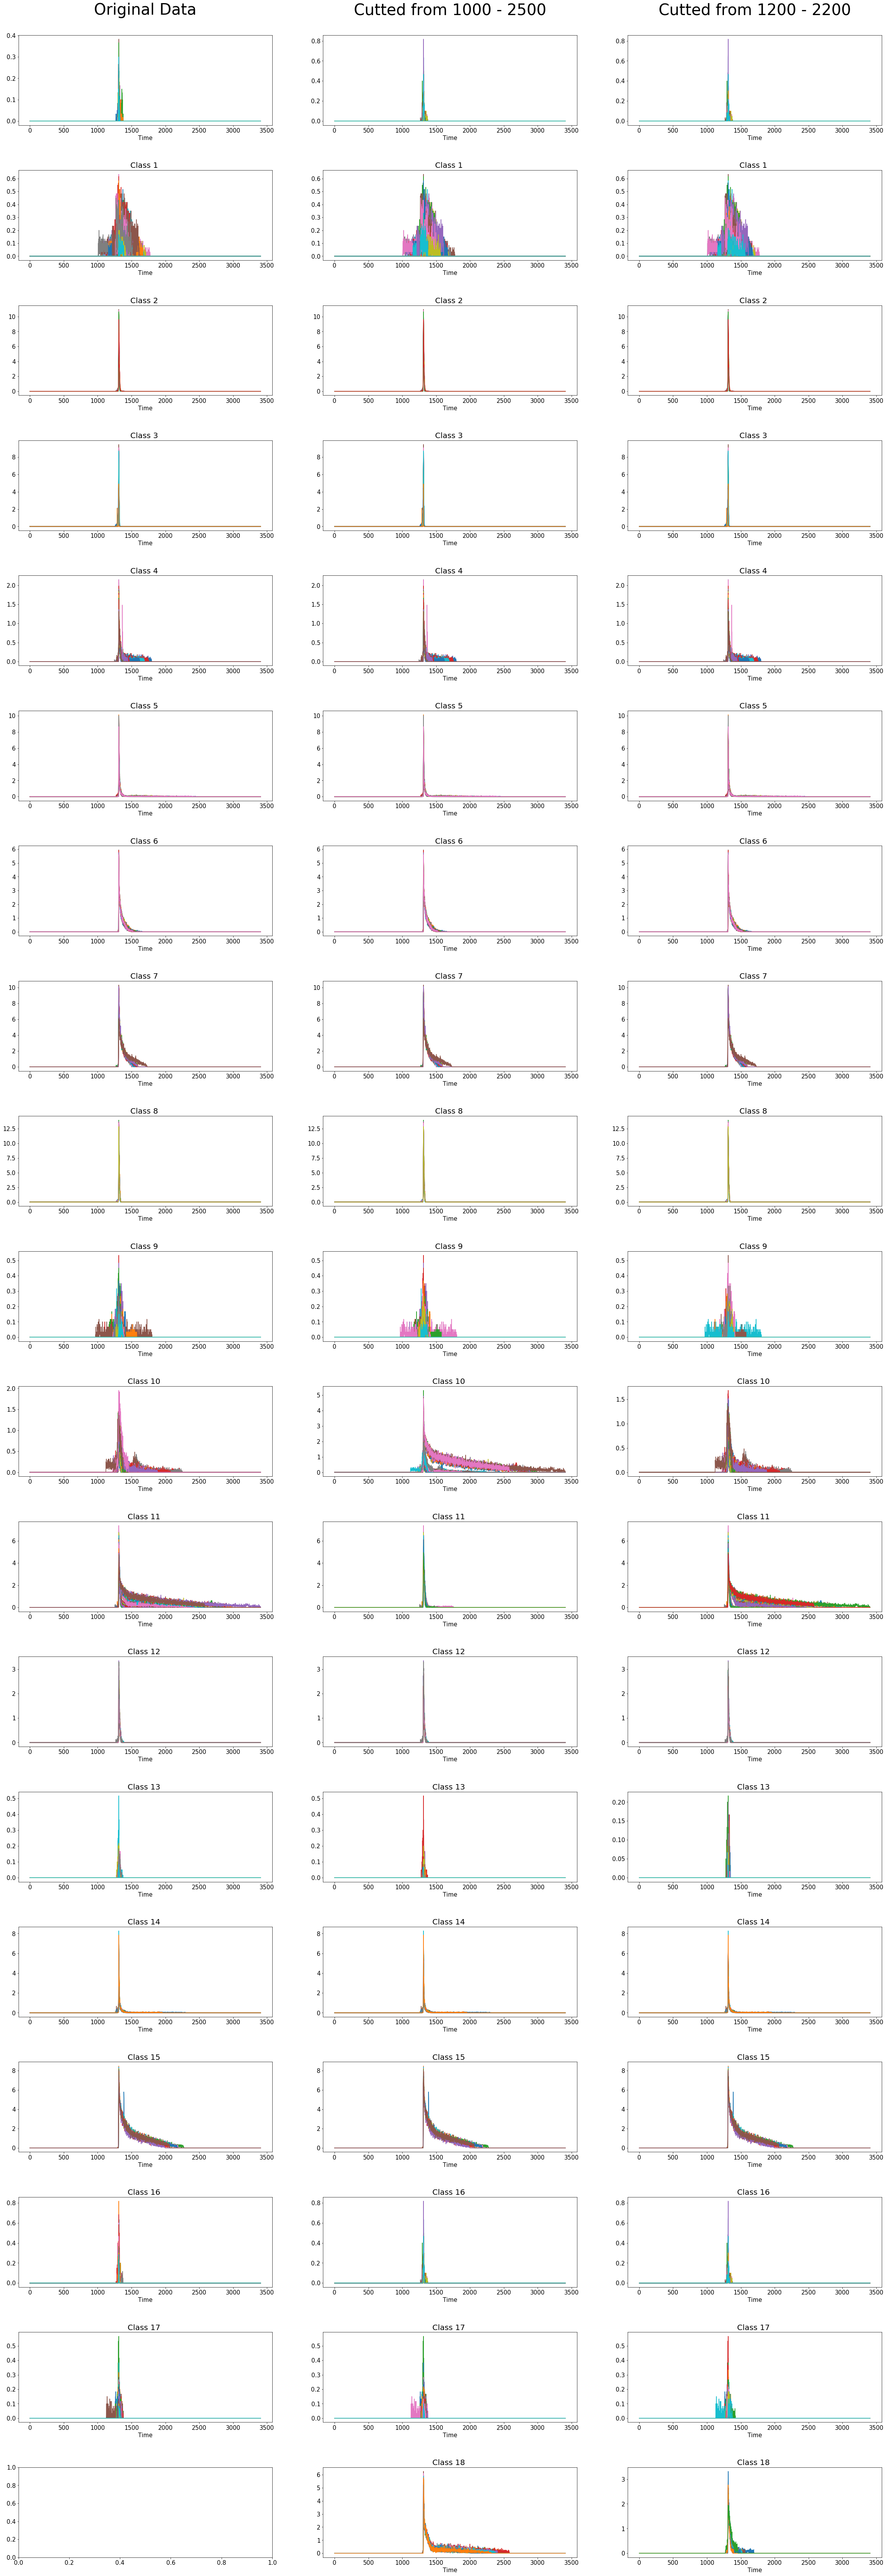

In [0]:
SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 70

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)



#fig = plt.figure(figsize=(40,40))
rows = int(np.ceil(max(len(mapped_dict2.keys()),len(mapped_dict.keys()))))
print(rows)

fig, axes = plt.subplots(nrows=rows, ncols=3,figsize=(40,120))
print(axes.shape)
fig.subplots_adjust(hspace=0.5, wspace=0.2)



cols = ["Original Data", "Cutted from 1000 - 2500", "Cutted from 1200 - 2200"] #1. cut 1000 - 2500 2. cut 1200 - 2200

for i,key in enumerate(np.sort(list(label_dict.keys()))):

    class_original = data_burst_by_time[label_dict[key][0]]
    
    
    ax = axes[i,0]
    #count = i*3
    #ax = fig.add_subplot(rows, 3, count+1)
    ax.set_xlabel("Time")
    ax.set_title("Class %i " % i, fontsize = 20)
    
    for burst in class_original[0:100]:
      ax.plot(burst)

mapped_dict_keys = np.sort(np.asarray(list(mapped_dict.keys())).astype("int")) 
mapped_dict_keys = list(mapped_dict_keys[np.where(mapped_dict_keys >= 0)]) + list(mapped_dict_keys[np.where(mapped_dict_keys < 0)])
print(mapped_dict_keys)
for i,key in enumerate(mapped_dict_keys):
  if key < 0:
    key = str(key)
  class_cutted1 =  data_burst_by_time[mapped_dict[key][0]] #dataset_cutted[mapped_dict[key][0]]
    
  ax1 = axes[i,1]
  #ax1 = fig.add_subplot(rows, 3, count+2)
  ax1.set_xlabel("Time")
  ax1.set_title("Class %i " % i, fontsize = 20)
    
  for burst in class_cutted1[0:100]:
    ax1.plot(burst)

      
mapped_dict2_keys = np.sort(np.asarray(list(mapped_dict2.keys())).astype("int")) 
mapped_dict2_keys = list(mapped_dict2_keys[np.where(mapped_dict2_keys >= 0)]) + list(mapped_dict2_keys[np.where(mapped_dict2_keys < 0)])
print(mapped_dict2_keys)      
for i,key in enumerate(mapped_dict2_keys):
  if key < 0:
    key = str(key)
  class_cutted2 =  data_burst_by_time[mapped_dict2[key][0]] #dataset_cutted2[mapped_dict2[key][0]]

    
  ax2 = axes[i,2]
  #ax2 = fig.add_subplot(rows, 3, count+3)
  ax2.set_xlabel("Time")
  ax2.set_title("Class %i " % i, fontsize = 20)
    
  for burst in class_cutted2[0:100]:
    ax2.plot(burst)
      
    
for a, col in zip(axes[0], cols):
    a.set_title(col, fontsize = 40, y=1.2)
  

In [0]:
def relabeling_labels(mapped_dict, mapping, labels):
 
  relabeled_labels = np.zeros(labels.shape) 
  relabeled_labels = relabeled_labels.astype(str)
  
  
  for key in mapped_dict.keys():
    
    if int(key) < 0:
      print(key)
      relabeled_labels[mapped_dict[key][0]] = str(key)
      
    else:
      to_mapped = np.where(np.rint(mapping) == int(mapping[key]))[0] # check if correspond to same class
      if len(to_mapped) > 1:
        multi_label = ','.join(map(str,to_mapped[np.argsort(mapping[to_mapped])]))
        print(multi_label)
        relabeled_labels[mapped_dict[key][0]] = multi_label
     
      
      else:
        #print(key)
        relabeled_labels[mapped_dict[key][0]] = str(key)
    
  return relabeled_labels

In [0]:
print(mapped_dict.keys())
print(final_mapped_labels)
#print(mapped_dict[17])

dict_keys([13, 9, 5, 3, 2, 4, 1, 11, 7, 8, 6, 14, 17, 10, 16, 0, 12, 15, '-17'])
[14.   6.   4.   3.   5.   2.  10.   8.   9.   1.  13.   7.  15.   0.
 11.  16.  14.2 12. ]


In [0]:
relabeled_labels_cutted = relabeling_labels(mapped_dict, final_mapped_labels,labels)
relabeled_labels_cutted2 = relabeling_labels(mapped_dict2, final_mapped_labels2, labels)

0,16
0,16
-17
0,16
0,16
-14


In [0]:
print(final_mapped_labels)
print(np.sort(np.unique(relabeled_labels_cutted)))
#print(np.sort(np.asarray(['0', '16', '-17', '1', '10', '11', '12', '13', '14', '17', '2', '3', '4', '5', '6', '7', '8', '9']).astype(int)))

[14.   6.   4.   3.   5.   2.  10.   8.   9.   1.  13.   7.  15.   0.
 11.  16.  14.2 12. ]
['-17' '0,16' '1' '10' '11' '12' '13' '14' '15' '17' '2' '3' '4' '5' '6'
 '7' '8' '9']


In [0]:
#culture_counts = [141, 531, 1656, 235, 231, 30, 156, 270, 416]
#culture_names = ["C11","C12","C24","C26","C51","C52","C53","C71","C72"]
culture_counts = [141, 531, 128, 194, 1782, 2112, 1656, 554, 235, 661, 143, 142, 2853, 61, 338, 231, 30, 156, 270, 416, 77, 96, 285]
culture_names = ["C11","C12","C15","C21","C22","C23","C24","C25","C26","C31","C32", "C33", "C34","C35","C36", "C51","C52","C53","C71","C72","C81","C82","C83"]
print(len(culture_counts))
print(len(culture_names))

23
23


In [0]:
def calculate_culture_class_contribution(culture_counts, culture_names, labels):
  cultures = []
  for i,culture in enumerate(culture_names):
    cultures += list(np.repeat(culture, culture_counts[i]))

  df_dict = {}
  df_dict["Culture"] = cultures
  df_dict["Class"] = labels

  df = pd.DataFrame.from_dict(df_dict)
  ncount = len(df)
  culture_class_contribution = df.groupby(["Culture","Class"]).size().reset_index(name='Counts')
  culture_class_contribution = pd.pivot_table(culture_class_contribution,
                         index=['Culture','Class'],
                         values='Counts',                            
                         fill_value = 0,
                         dropna=False,
                         aggfunc=np.sum).reset_index()
  
  return culture_class_contribution

In [0]:
culture_class_contribution = calculate_culture_class_contribution(culture_counts, culture_names, labels)#labels.astype(str))
#culture_class_contribution_cutted = calculate_culture_class_contribution(culture_counts, culture_names, relabeled_labels_cutted)
#culture_class_contribution_cutted2 = calculate_culture_class_contribution(culture_counts, culture_names, relabeled_labels_cutted2)

In [0]:
culture_class_contribution.head()

,Culture,Class,Counts
0,C11,0,34
1,C11,1,0
2,C11,2,0
3,C11,3,0
4,C11,4,26


In [0]:
print(np.asarray(list(culture_class_contribution[culture_class_contribution["Culture"] == "C11"]["Counts"]))/141)
print(np.asarray(list(culture_class_contribution[culture_class_contribution["Class"] == 11]["Counts"]))/np.asarray(culture_counts))

[0.08510638 0.         0.18439716 0.41134752 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.21276596 0.         0.         0.07092199 0.03546099]
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.03630862 0.         0.
 0.00315457 0.         0.03550296 0.         0.         0.
 0.         0.         0.         0.125      0.03157895]


In [0]:
with open("/content/gdrive/My Drive/Burst_data/color_map.txt") as f:
    color_map = f.read().splitlines()
color_map = np.reshape(color_map,(16,16))

In [0]:
print(len(colors))

20


In [0]:
print(culture_class_contribution_cutted2["Class"].unique())

['-14' '0,16' '1' '10' '11' '12' '13' '14' '15' '17' '2' '3' '4' '5' '6'
 '7' '8' '9']


In [0]:
print(int('-14'.split(",")[0]))

-14


In [0]:
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 5.0 


def plot_culture_class_contribution(culture_counts, culture_names, culture_class_contribution, colors):
  # The position of the bars on the x-axis

  r = range(len(culture_names)) 
  keys = culture_class_contribution["Class"].unique()
  
  print(keys)
  barWidth = 1

  fig, ax = plt.subplots(figsize=(30,20))

  bar_array = np.zeros((len(keys),len(culture_names)))
  bottom = 0
  
  for i, c in enumerate(keys):
    bar = list(culture_class_contribution[culture_class_contribution["Class"] == c]["Counts"])
    bar_normalized = np.asarray(bar)/np.asarray(culture_counts)
    
    
    
    bar_array[i] = bar_normalized
    
    
    if isinstance(c, str):
      label = c.split(",")
      
      if len(label) > 1:
        color1 = colors[int(label[0])]
        color2 = colors[int(label[1])]



        axi = ax.bar(r,bar_normalized,bottom=bottom,edgecolor='white', width=barWidth, label = "Class %s" % c, color = color1,  zorder=0)
        # draw hatch
        ax.bar(r,bar_normalized,bottom=bottom, color='none', width=barWidth, edgecolor=color2, hatch="/", zorder = 1)
        # draw edge
        ax.bar(r,bar_normalized,bottom=bottom, color='none', width=barWidth, edgecolor='white', zorder=1)

        bottom += bar_normalized
    
      else:
        count_missing_classes = 0
        if int(label[0]) < 0:
          color = colors[len(keys)+ count_missing_classes]
          label = "Class %d (new)" % (len(keys) + count_missing_classes)
          count_missing_classes += 1
        else:
          color = colors[int(label[0])]
          label = "Class %s" % c

        axi = ax.bar(r,bar_normalized,bottom=bottom,edgecolor='white', width=barWidth, label = label, color = color)
        bottom += bar_normalized
    else:
      label = c
      count_missing_classes = 0
      if label < 0:
        color = colors[len(keys)+ count_missing_classes]
        label = "Class %d (new)" % (len(keys) + count_missing_classes)
        count_missing_classes += 1
      else:
        color = colors[label]
        label = "Class %s" % c

      axi = ax.bar(r,bar_normalized,bottom=bottom,edgecolor='white', width=barWidth, label = label, color = color)
      bottom += bar_normalized
      

    for p in axi:
      width, height = p.get_width(), p.get_height()
      x, y = p.get_xy() 
      if height > 0.015:
        annotation = '{:.2f}%'.format(height*100)
        if len(annotation) > 5:
          ax.annotate(annotation, (p.get_x(), p.get_y()+ 0.3*height),fontsize=16, fontweight='bold', color='white')
        else: 
          ax.annotate(annotation, (p.get_x()+ 0.1*width, p.get_y()+ 0.3*height),fontsize=16, fontweight='bold', color='white')

  #ax.set_facecolor('Black')
  ax.set_xticks(r)
  ax.set_xticklabels(culture_names,fontsize = 25)
  ax.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize=25)
  ax.set_xlabel("Culture", fontsize = 30)
  ax.set_ylabel("%Percent of Bursts in Culture", fontsize = 30)
  ax.set_ylim((0,1.05))
  #ax.legend(fontsize = 25)
  ax.legend(bbox_to_anchor=(0.95, 0.85),
            ncol=1, fancybox=True, fontsize = 25)
  ax.set_title("Proportion of Burst Classes per Culture",fontsize = 40,pad = 30)  # 1. cut 1000 - 2500 2. cut 1200 - 2200

In [0]:
colors = list(color_map[:-2,7]) + list(color_map[5:11,15])
np.random.seed(77)
np.random.shuffle(colors)
#colors = ["#7C2B73", "#4E5F37", "#5D5462", "#90956F", "#6AA776", "#DBCBF6", "#DA71FF", "#987C95", "#160B00", "#20221A", "#6B8295", "#00E0E4", "#102401", "#1B782A", "#DAA9B5", "#B0415D", "#859253", "#97A094", "#06E3C4", "#47688C"]
#colors = cm.viridis(np.linspace(0, 1, 20)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


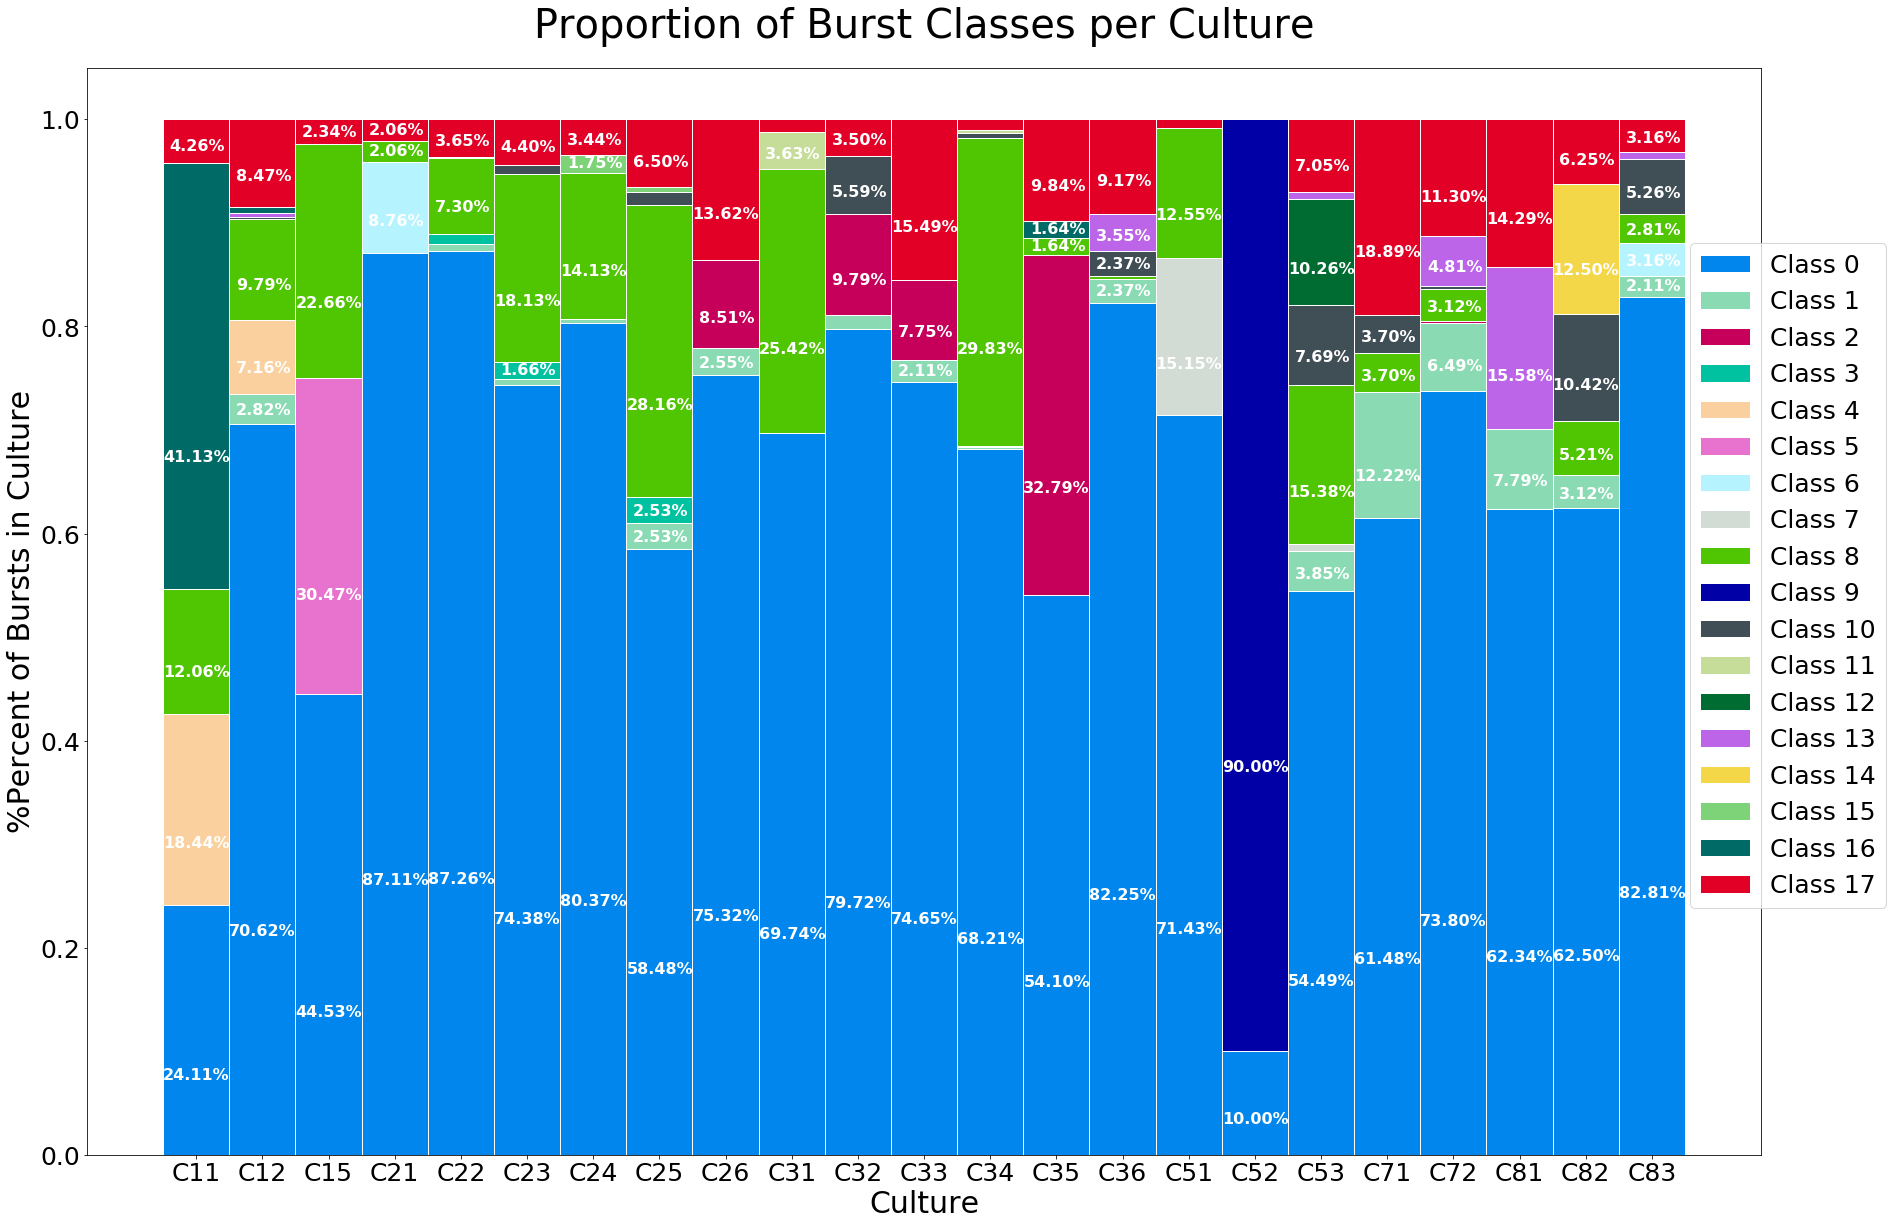

In [0]:
plot_culture_class_contribution(culture_counts, culture_names, culture_class_contribution, colors)

In [0]:
def plot_culture_class_contribution(culture_counts, culture_names, culture_class_contribution, colors):
  # The position of the bars on the x-axis

  r = range(len(culture_names)) 
  keys = culture_class_contribution["Class"].unique()
  
  print(keys)
  barWidth = 1

  fig, ax = plt.subplots(figsize=(30,20))

  bar_array = np.zeros((len(keys),len(culture_names)))
  bottom = 0
  
  for i, c in enumerate(keys):
    bar = list(culture_class_contribution[culture_class_contribution["Class"] == c]["Counts"])
    bar_normalized = np.asarray(bar)/np.asarray(culture_counts)
    
    
    label = c.split(",")
    
    bar_array[i] = bar_normalized
    
    
    
      
    if len(label) > 1:
      color1 = colors[int(label[0])]
      color2 = colors[int(label[1])]
      
      
      
      axi = ax.bar(r,bar_normalized,bottom=bottom,edgecolor='white', width=barWidth, label = "Class %s" % c, color = color1,  zorder=0)
      # draw hatch
      ax.bar(r,bar_normalized,bottom=bottom, color='none', width=barWidth, edgecolor=color2, hatch="/", lw=2., zorder = 1)
      # draw edge
      ax.bar(r,bar_normalized,bottom=bottom, color='none', width=barWidth, edgecolor='white', zorder=1, lw=2.)
      
      bottom += bar_normalized
    
    else:
      count_missing_classes = 0
      if int(label[0]) < 0:
        color = colors[len(keys)+ count_missing_classes+1]
        count_missing_classes += 1
      else:
        color = colors[int(label[0])]

      axi = ax.bar(r,bar_normalized,bottom=bottom,edgecolor='white', width=barWidth, label = "Class %s" % c, color = color)
      bottom += bar_normalized

    for p in axi:
      width, height = p.get_width(), p.get_height()
      x, y = p.get_xy() 
      if height > 0.015:
        annotation = '{:.2f}%'.format(height*100)
        if len(annotation) > 5:
          ax.annotate(annotation, (p.get_x(), p.get_y()+ 0.3*height),fontsize=16, fontweight='bold', color='white')
        else: 
          ax.annotate(annotation, (p.get_x()+ 0.1*width, p.get_y()+ 0.3*height),fontsize=16, fontweight='bold', color='white')

  #ax.set_facecolor('Black')
  ax.set_xticks(r)
  ax.set_xticklabels(culture_names,fontsize = 25)
  ax.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize=25)
  ax.set_xlabel("Culture", fontsize = 30)
  ax.set_ylabel("%Percent of Bursts in Culture", fontsize = 30)
  ax.set_ylim((0,1.05))
  #ax.legend(fontsize = 25)
  ax.legend(bbox_to_anchor=(0.95, 0.85),
            ncol=1, fancybox=True, fontsize = 25)
  ax.set_title("Number of detected Bursts per Culture",fontsize = 40,pad = 30)